L22-7501,L22-7515,L227540,L22-7492




In [ ]:
!pip install tensorflow


In [ ]:
pip install pillow torchvision


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 7.9 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 30.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.6 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.2 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 80.0 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.8.93
    Uninstalling nvidia-nvjitlink-cu12-12.8.93:
      Successfully uninstalled nvidia-nvjitlink-cu12-12.8.93
  Attempting uninstall: nvidia-curand-cu12
    Found existing installation: nvidia-curand-cu12 10.3.9.90
    Uninstalling nvidia-curand-cu12-1

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Reshape, Conv2DTranspose, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
import cv2 #


2025-05-10 13:33:04.112297: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746883984.315470      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746883984.372525      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


**Downlaoding Image From URL**

In [ ]:
import pandas as pd
import os
import requests
from concurrent.futures import ThreadPoolExecutor, as_completed
from tqdm import tqdm

df = pd.read_csv("/kaggle/input/fashion-csv/fashion.csv")

image_dir = "fashion_images"
os.makedirs(image_dir, exist_ok=True)

def download_image(index, url):
    image_filename = os.path.join(image_dir, f"{index}.jpg")
    try:
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            with open(image_filename, 'wb') as f:
                f.write(response.content)
            return image_filename
    except Exception as e:
        pass
    return None
image_paths = [None] * len(df)

with ThreadPoolExecutor(max_workers=20) as executor:
    futures = {
        executor.submit(download_image, idx, row["ImageURL"]): idx
        for idx, row in df.iterrows()
    }

    for future in tqdm(as_completed(futures), total=len(futures)):
        idx = futures[future]
        result = future.result()
        image_paths[idx] = result

# Add image paths to DataFrame
df["ImagePath"] = image_paths
df.to_csv("fashion_dataset_with_images.csv", index=False)

100%|██████████| 2906/2906 [00:17<00:00, 163.69it/s]


**# Load dataset**

In [ ]:

df = pd.read_csv('/kaggle/working/fashion_dataset_with_images.csv')


df.head()

,ProductId,Gender,Category,SubCategory,ProductType,Colour,Usage,ProductTitle,Image,ImageURL,ImagePath
0,42419,Girls,Apparel,Topwear,Tops,White,Casual,Gini and Jony Girls Knit White Top,42419.jpg,http://assets.myntassets.com/v1/images/style/p...,fashion_images/0.jpg
1,34009,Girls,Apparel,Topwear,Tops,Black,Casual,Gini and Jony Girls Black Top,34009.jpg,http://assets.myntassets.com/v1/images/style/p...,fashion_images/1.jpg
2,40143,Girls,Apparel,Topwear,Tops,Blue,Casual,Gini and Jony Girls Pretty Blossom Blue Top,40143.jpg,http://assets.myntassets.com/v1/images/style/p...,fashion_images/2.jpg
3,23623,Girls,Apparel,Topwear,Tops,Pink,Casual,Doodle Kids Girls Pink I love Shopping Top,23623.jpg,http://assets.myntassets.com/v1/images/style/p...,fashion_images/3.jpg
4,47154,Girls,Apparel,Bottomwear,Capris,Black,Casual,Gini and Jony Girls Black Capris,47154.jpg,http://assets.myntassets.com/v1/images/style/p...,fashion_images/4.jpg


In [ ]:
df['Gender'].unique()

array(['Girls', 'Boys', 'Men', 'Women'], dtype=object)

In [ ]:
rows, cols = df.shape
print(f"Dataset contains {rows} rows and {cols} columns.")

Dataset contains 2906 rows and 11 columns.


**Class Imbalance**

In [ ]:
from imblearn.over_sampling import SMOTE
import numpy as np

if 'Category' in df.columns:
    class_counts = df['Category'].value_counts()
    print("\nClass Distribution Before Balancing:\n", class_counts)

    # Check for class imbalance (if min class < 50% of max class)
    min_class_count = class_counts.min()
    max_class_count = class_counts.max()

    if min_class_count / max_class_count < 0.5:
        print("\nApplying SMOTE to balance the dataset...\n")

        numerical_features = df.select_dtypes(include=np.number).drop(columns=['Category'], errors='ignore')

        smote = SMOTE(random_state=42)
        X_resampled, y_resampled = smote.fit_resample(numerical_features, df['Category'])
        balanced_df = pd.DataFrame(X_resampled, columns=numerical_features.columns)
        balanced_df['Category'] = y_resampled

        print("\nClass Distribution After Balancing:\n", balanced_df['Category'].value_counts())
    else:
        print("\nDataset is already balanced. No SMOTE applied.\n")
else:
    print("Category column not found in the dataset.")


Class Distribution Before Balancing:
 Category
Footwear    1580
Apparel     1326
Name: count, dtype: int64

Dataset is already balanced. No SMOTE applied.



**Combining Images**

**Checking nulls**

In [ ]:
df.isnull().sum()

,0
ProductId,0
Gender,0
Category,0
SubCategory,0
ProductType,0
Colour,0
Usage,0
ProductTitle,0
Image,0
ImageURL,0


In [ ]:
import pandas as pd
import re



def strip_before_gender(name):
    if pd.isna(name):
        return name
    match = re.search(r'\b(Girls|Boys|Men|Women)\b', name, flags=re.IGNORECASE)
    if match:
        return name[match.start():]
    return name

df['CleanedProductTitle'] = df['ProductTitle'].apply(strip_before_gender)
print(df[['ProductTitle','CleanedProductTitle' ]].head())


                                  ProductTitle             CleanedProductTitle
0           Gini and Jony Girls Knit White Top            Girls Knit White Top
1                Gini and Jony Girls Black Top                 Girls Black Top
2  Gini and Jony Girls Pretty Blossom Blue Top   Girls Pretty Blossom Blue Top
3   Doodle Kids Girls Pink I love Shopping Top  Girls Pink I love Shopping Top
4             Gini and Jony Girls Black Capris              Girls Black Capris


In [ ]:
import re

def clean_text(text):
    text = re.sub(r'http\S+|www\S+', '', text)
    text = re.sub(r'[^a-z0-9 ]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

df['Usage_clean'] = df['Usage'].apply(clean_text)
df['ProductType_clean'] = df['CleanedProductTitle'].apply(clean_text)

df["CombinedTitle"] = df['Usage_clean'] +  " " + df['CleanedProductTitle']
print(df["CombinedTitle"].head())


0              casual Girls Knit White Top
1                   casual Girls Black Top
2     casual Girls Pretty Blossom Blue Top
3    casual Girls Pink I love Shopping Top
4                casual Girls Black Capris
Name: CombinedTitle, dtype: object


**Padding and Tokenizizng**

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(df['CombinedTitle'])
sequences = tokenizer.texts_to_sequences(df['CombinedTitle'])

max_length = max(len(seq) for seq in sequences)

padded_captions = pad_sequences(sequences, maxlen=max_length, padding='post')

vocab_size = len(tokenizer.word_index) + 1

print(f"Vocabulary Size: {vocab_size}")
print(f"Max Sequence Length: {max_length}")


Vocabulary Size: 1155
Max Sequence Length: 12


**Preprocessing iamge**

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import numpy as np

image_size = (64, 64)

def load_and_preprocess_image(img_path):
    img = load_img(img_path, target_size=image_size)
    img = img_to_array(img) / 255.0
    return img

df = df[df['ImagePath'].notnull() & df['CombinedTitle'].notnull()]

image_data = np.array([load_and_preprocess_image(path) for path in df['ImagePath']])


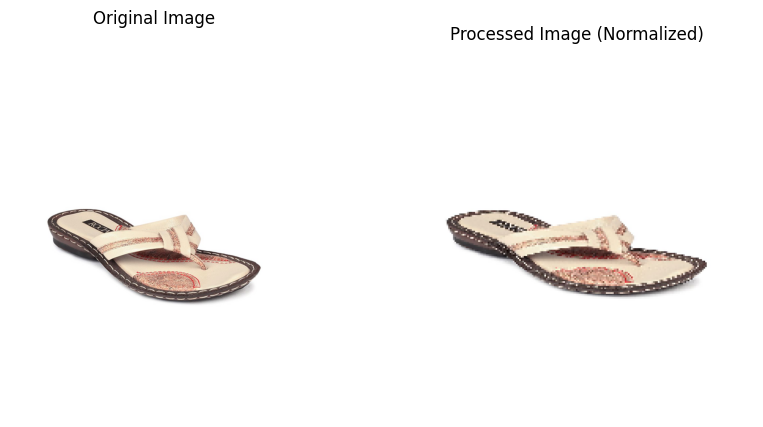

In [ ]:
import matplotlib.pyplot as plt
import random
from PIL import Image
valid_image_paths = df['ImagePath'].dropna().tolist()
random_image_path = random.choice(valid_image_paths)

original_image = Image.open(random_image_path)
processed_image = load_and_preprocess_image(random_image_path)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(original_image)
axes[0].set_title("Original Image")
axes[0].axis("off")

axes[1].imshow(processed_image)
axes[1].set_title("Processed Image (Normalized)")
axes[1].axis("off")

plt.show()



# **Models**

**Simple GAN**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, LSTM, Concatenate, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Model

# Parameters
vocab_size = 1155
max_caption_len = 12
embedding_dim = 100
noise_dim = 100
image_shape = (64, 64, 3)

def build_text_encoder():
    caption_input = Input(shape=(max_caption_len,))
    x = Embedding(vocab_size, embedding_dim)(caption_input)
    x = LSTM(128)(x)
    return Model(caption_input, x, name="TextEncoder")

# Generator
def build_generator():
    text_encoder = build_text_encoder()
    noise_input = Input(shape=(noise_dim,))
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    merged = Concatenate()([noise_input, text_features])

    x = Dense(8*8*256, use_bias=False)(merged)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh')(x)

    return Model([noise_input, caption_input], x, name="Generator")

# Discriminator
def build_discriminator():
    text_encoder = build_text_encoder()
    image_input = Input(shape=image_shape)
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    text_features = Dense(image_shape[0] * image_shape[1])(text_features)
    text_features = Reshape((image_shape[0], image_shape[1], 1))(text_features)

    merged = Concatenate()([image_input, text_features])

    x = Conv2D(64, (5,5), strides=(2,2), padding='same')(merged)
    x = LeakyReLU()(x)

    x = Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model([image_input, caption_input], x, name="Discriminator")

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_24            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_23            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        232,748 │ input_layer_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_7             │ (None, 228)            │              0 │ input_layer_23[0][0],  │
│ (Concatenate)             │                        │                │ TextEncoder[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_18 (Dense)          │ (None, 16384)          │      3,735,552 │ concatenate_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_15    │ (None, 16384)          │         65,536 │ dense_18[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_21            │ (None, 16384)          │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_8 (Reshape)       │ (None, 8, 8, 256)      │              0 │ leaky_re_lu_21[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_18       │ (None, 16, 16, 128)    │        819,200 │ reshape_8[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_16    │ (None, 16, 16, 128)    │            512 │ conv2d_transpose_18[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_22            │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_19       │ (None, 32, 32, 64)     │        204,800 │ leaky_re_lu_22[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_17    │ (None, 32, 32, 64)     │            256 │ conv2d_transpose_19[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_23            │ (None, 32, 32, 64)     │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├──────────────────────

 Total params: 5,063,407 (19.32 MB)

 Trainable params: 5,030,255 (19.19 MB)

 Non-trainable params: 33,152 (129.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_27            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        232,748 │ input_layer_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_19 (Dense)          │ (None, 4096)           │        528,384 │ TextEncoder[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_26            │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_9 (Reshape)       │ (None, 64, 64, 1)      │              0 │ dense_19[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_8             │ (None, 64, 64, 4)      │              0 │ input_layer_26[0][0],  │
│ (Concatenate)             │                        │                │ reshape_9[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_6 (Conv2D)         │ (None, 32, 32, 64)     │          6,464 │ concatenate_8[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_24            │ (None, 32, 32, 64)     │              0 │ conv2d_6[0][0]         │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_7 (Conv2D)         │ (None, 16, 16, 128)    │        204,928 │ leaky_re_lu_24[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_18    │ (None, 16, 16, 128)    │            512 │ conv2d_7[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_25            │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_3 (Flatten)       │ (None, 32768)          │              0 │ leaky_re_lu_25[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 1)              │         32,769 │ flatten_3[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,005,805 (3.84 MB)

 Trainable params: 1,005,549 (3.84 MB)

 Non-trainable params: 256 (1.00 KB)

**Traing on 50 epochs**


Epoch 1/50
Generator Loss: 2.6496, Discriminator Loss: 0.1159

Epoch 2/50
Generator Loss: 3.3716, Discriminator Loss: 0.1672

Epoch 3/50
Generator Loss: 6.1282, Discriminator Loss: 1.3328

Epoch 4/50
Generator Loss: 3.5231, Discriminator Loss: 0.3079

Epoch 5/50
Generator Loss: 5.2779, Discriminator Loss: 0.5075

Epoch 6/50
Generator Loss: 1.6302, Discriminator Loss: 0.3386

Epoch 7/50
Generator Loss: 5.1169, Discriminator Loss: 0.7451

Epoch 8/50
Generator Loss: 5.3136, Discriminator Loss: 0.7309

Epoch 9/50
Generator Loss: 4.1762, Discriminator Loss: 0.0411

Epoch 10/50
Generator Loss: 0.6229, Discriminator Loss: 1.0761

Epoch 11/50
Generator Loss: 1.9799, Discriminator Loss: 0.2859

Epoch 12/50
Generator Loss: 4.4205, Discriminator Loss: 0.0769

Epoch 13/50
Generator Loss: 4.9183, Discriminator Loss: 0.1885

Epoch 14/50
Generator Loss: 4.5824, Discriminator Loss: 0.0661

Epoch 15/50
Generator Loss: 6.1058, Discriminator Loss: 0.2605

Epoch 16/50
Generator Loss: 4.5587, Discriminato

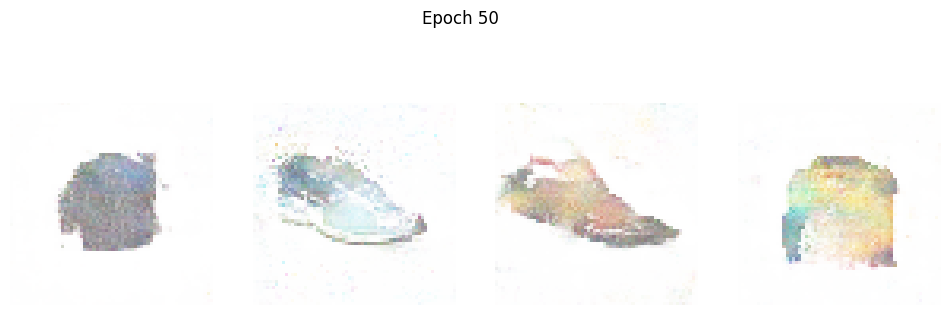

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

BATCH_SIZE = 64
EPOCHS = 50
noise_dim = 100
BUFFER_SIZE = image_data.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)

        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, captions, epoch):
    noise = tf.random.normal([len(captions), noise_dim])
    generated_images = model([noise, captions], training=False)

    plt.figure(figsize=(12, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)  # Rescale images
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# Define 2 specific captions to monitor during training
specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Expressions Yellow T-shirt"
]
specific_captions_padded = tokenizer.texts_to_sequences(specific_captions)
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(specific_captions_padded, maxlen=max_caption_len, padding='post')


for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for batch_images, batch_captions in dataset:
        g_loss, d_loss = train_step(batch_images, batch_captions)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")

    if epoch == EPOCHS:
        sample_captions = tf.convert_to_tensor(specific_captions_padded)
        generate_and_save_images(generator, sample_captions, epoch)


**Training on 200**


Epoch 1/200
Generator Loss: 2.5260, Discriminator Loss: 0.1618

Epoch 2/200
Generator Loss: 4.5836, Discriminator Loss: 0.9371

Epoch 3/200
Generator Loss: 1.1776, Discriminator Loss: 0.5176

Epoch 4/200
Generator Loss: 3.4073, Discriminator Loss: 0.2794

Epoch 5/200
Generator Loss: 1.8403, Discriminator Loss: 0.2405

Epoch 6/200
Generator Loss: 1.9743, Discriminator Loss: 0.2103

Epoch 7/200
Generator Loss: 1.6652, Discriminator Loss: 0.4857

Epoch 8/200
Generator Loss: 3.1720, Discriminator Loss: 0.1877

Epoch 9/200
Generator Loss: 2.1810, Discriminator Loss: 0.7532

Epoch 10/200
Generator Loss: 2.3668, Discriminator Loss: 0.1731

Epoch 11/200
Generator Loss: 3.8293, Discriminator Loss: 0.6029

Epoch 12/200
Generator Loss: 1.4747, Discriminator Loss: 0.3523

Epoch 13/200
Generator Loss: 3.4500, Discriminator Loss: 0.3814

Epoch 14/200
Generator Loss: 2.0137, Discriminator Loss: 0.2145

Epoch 15/200
Generator Loss: 0.8274, Discriminator Loss: 0.7180

Epoch 16/200
Generator Loss: 3.32

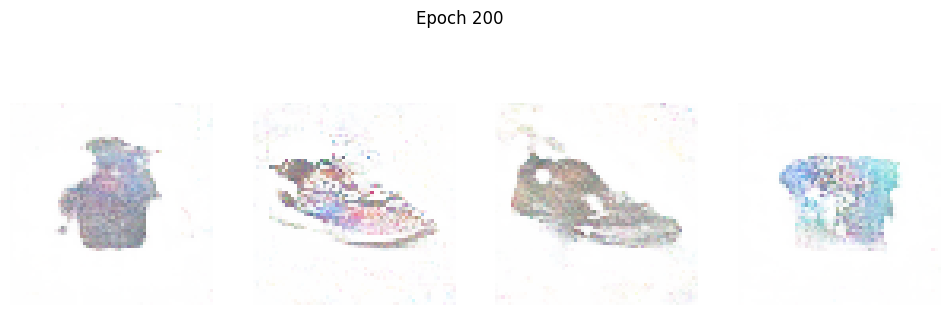

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

BATCH_SIZE = 64
EPOCHS = 200
noise_dim = 100
BUFFER_SIZE = image_data.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)

        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Generate and save images for specific captions
def generate_and_save_images(model, captions, epoch):
    noise = tf.random.normal([len(captions), noise_dim])
    generated_images = model([noise, captions], training=False)

    plt.figure(figsize=(12, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)  # Rescale images
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

# Define 2 specific captions to monitor during training
specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Expressions Yellow T-shirt"
]

# Convert captions to padded format
specific_captions_padded = tokenizer.texts_to_sequences(specific_captions)
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(specific_captions_padded, maxlen=max_caption_len, padding='post')

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for batch_images, batch_captions in dataset:
        g_loss, d_loss = train_step(batch_images, batch_captions)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


    if epoch == EPOCHS:
        sample_captions = tf.convert_to_tensor(specific_captions_padded)
        generate_and_save_images(generator, sample_captions, epoch)


**TRainubf on 600**


Epoch 1/600
Generator Loss: 2.3808, Discriminator Loss: 0.1481

Epoch 2/600
Generator Loss: 0.6316, Discriminator Loss: 1.2029

Epoch 3/600
Generator Loss: 3.0642, Discriminator Loss: 0.1780

Epoch 4/600
Generator Loss: 1.3300, Discriminator Loss: 0.4325

Epoch 5/600
Generator Loss: 3.9228, Discriminator Loss: 1.2807

Epoch 6/600
Generator Loss: 2.4447, Discriminator Loss: 0.2204

Epoch 7/600
Generator Loss: 5.0424, Discriminator Loss: 0.6277

Epoch 8/600
Generator Loss: 2.4467, Discriminator Loss: 0.4884

Epoch 9/600
Generator Loss: 0.5616, Discriminator Loss: 1.3174

Epoch 10/600
Generator Loss: 1.5579, Discriminator Loss: 0.3360

Epoch 11/600
Generator Loss: 4.0798, Discriminator Loss: 0.0509

Epoch 12/600
Generator Loss: 4.7634, Discriminator Loss: 0.9401

Epoch 13/600
Generator Loss: 4.1517, Discriminator Loss: 0.5606

Epoch 14/600
Generator Loss: 1.7067, Discriminator Loss: 0.3765

Epoch 15/600
Generator Loss: 2.4072, Discriminator Loss: 0.2156

Epoch 16/600
Generator Loss: 3.55

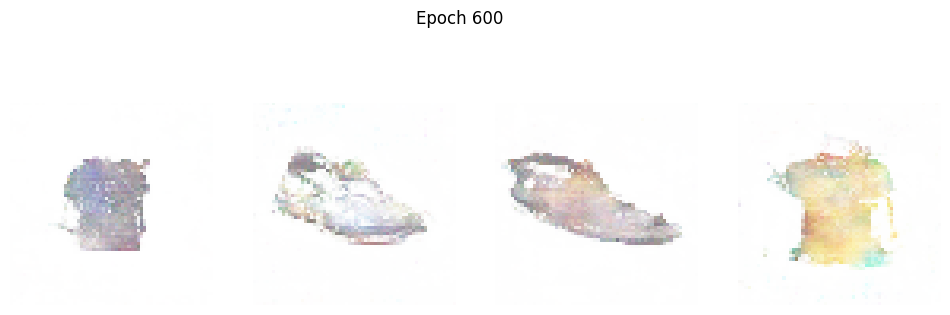

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os

BATCH_SIZE = 64
EPOCHS = 600
noise_dim = 100
BUFFER_SIZE = image_data.shape[0]

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)


generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)

        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, captions, epoch):
    noise = tf.random.normal([len(captions), noise_dim])
    generated_images = model([noise, captions], training=False)

    plt.figure(figsize=(12, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
    plt.suptitle(f'Epoch {epoch}')
    plt.show()

specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Expressions Yellow T-shirt"
]

specific_captions_padded = tokenizer.texts_to_sequences(specific_captions)
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(specific_captions_padded, maxlen=max_caption_len, padding='post')
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for batch_images, batch_captions in dataset:
        g_loss, d_loss = train_step(batch_images, batch_captions)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")
    if epoch == EPOCHS:
        sample_captions = tf.convert_to_tensor(specific_captions_padded)
        generate_and_save_images(generator, sample_captions, epoch)


**FID GAN**

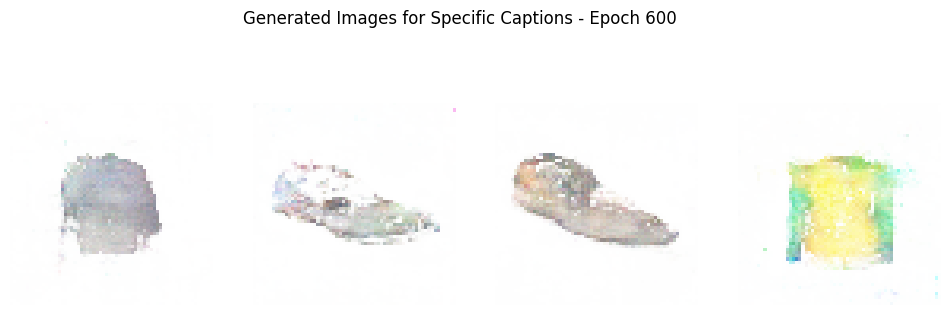

FID Score: 12.012


In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)


def load_image(image_path, img_size=(64, 64)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

# FID Calculation function
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    real_act = model(real_images)
    gen_act = model(generated_images)


    mu1, sigma1 = np.mean(real_act, axis=0), np.cov(real_act, rowvar=False)
    mu2, sigma2 = np.mean(gen_act, axis=0), np.cov(gen_act, rowvar=False)
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

def calculate_inception_score(images, splits=10):
    model = InceptionV3(include_top=True, weights='imagenet')
    images_resized = preprocess_images(images)
    preds = model(images_resized).numpy()

    scores = []
    N = preds.shape[0]
    split_size = N // splits
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * (np.log(p + 1e-10) - np.log(py + 1e-10))) for p in part])))
    return np.mean(scores), np.std(scores)

# Function to generate images
def generate_and_save_images(generator, noise, captions, epoch):
    generated_images = generator([noise, captions], training=False)

    # Visualize the generated images
    plt.figure(figsize=(12, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i + 1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)  # Rescale images
        plt.axis('off')
    plt.suptitle(f'Generated Images for Specific Captions - Epoch {600}')
    plt.show()

# Tokenizing and padding captions
specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Expressions Yellow T-shirt"
]

specific_captions_tokenized = tokenizer.texts_to_sequences(specific_captions)
max_caption_len = 12
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(specific_captions_tokenized, maxlen=max_caption_len, padding='post')
specific_captions_padded = tf.convert_to_tensor(specific_captions_padded)

noise_dim = 100
noise = tf.random.normal([len(specific_captions), noise_dim])

generated_images = generator([noise, specific_captions_padded], training=False)
generate_and_save_images(generator, noise, specific_captions_padded, epoch=1)

real_image_paths = [
    '/kaggle/input/iamgestotest/762maroonkurta.jpg',
    '/kaggle/input/iamgestotest/2000white sports.jpg',
    '/kaggle/input/iamgestotest/1500men snadals.jpg',
    '/kaggle/input/iamgestotest/1208shirtsmarvel.jpg'
]

real_images = np.array([load_image(path) for path in real_image_paths])
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score": {fid_score:.4f})



# **Style Gan**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, LSTM, Concatenate, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D, Add
from tensorflow.keras.models import Model

# Parameters
vocab_size = 1155
max_caption_len = 12
embedding_dim = 100
noise_dim = 100
image_shape = (64, 64, 3)


def build_text_encoder():
    caption_input = Input(shape=(max_caption_len,))
    x = Embedding(vocab_size, embedding_dim)(caption_input)
    x = LSTM(128)(x)
    return Model(caption_input, x, name="TextEncoder")

def build_mapping_network():
    input = Input(shape=(noise_dim,))
    x = Dense(256)(input)
    x = LeakyReLU()(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    x = Dense(256)(x)
    x = LeakyReLU()(x)
    return Model(input, x, name="MappingNetwork")

# StyleGAN Generator
def build_generator():
    text_encoder = build_text_encoder()
    mapping_network = build_mapping_network()

    noise_input = Input(shape=(noise_dim,))
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    style_vector = mapping_network(noise_input)
    merged = Concatenate()([text_features, style_vector])

    # Initial fully connected layer
    x = Dense(8 * 8 * 256, use_bias=False)(merged)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 256))(x)

    # Progressive layers with style injection
    x = Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh')(x)

    return Model([noise_input, caption_input], x, name="Generator")

def build_discriminator():
    text_encoder = build_text_encoder()
    image_input = Input(shape=image_shape)
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    text_features = Dense(image_shape[0] * image_shape[1])(text_features)
    text_features = Reshape((image_shape[0], image_shape[1], 1))(text_features)

    merged = Concatenate()([image_input, text_features])

    x = Conv2D(64, (5,5), strides=(2,2), padding='same')(merged)
    x = LeakyReLU()(x)

    x = Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model([image_input, caption_input], x, name="Discriminator")

generator = build_generator()
discriminator = build_discriminator()

generator.summary()
discriminator.summary()




I0000 00:00:1746897877.263411      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_2             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        362,848 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ MappingNetwork            │ (None, 256)            │        157,440 │ input_layer_2[0][0]    │
│ (Functional)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate (Concatenate) │ (None, 384)            │              0 │ TextEncoder[0][0],     │
│                           │                        │                │ MappingNetwork[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_3 (Dense)           │ (None, 16384)          │      6,291,456 │ concatenate[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 16384)          │         65,536 │ dense_3[0][0]          │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_3 (LeakyReLU) │ (None, 16384)          │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape (Reshape)         │ (None, 8, 8, 256)      │              0 │ leaky_re_lu_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose          │ (None, 16, 16, 128)    │        819,200 │ reshape[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 16, 16, 128)    │            512 │ conv2d_transpose[0][0] │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_4 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_1        │ (None, 32, 32, 64)     │        204,800 │ leaky_re_lu_4[0][0]    │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 32, 32, 64)     │            256 │ conv2d_transpose_1[0]… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_5 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ batch_normalization_2… │
├──────────────────────

 Total params: 7,906,851 (30.16 MB)

 Trainable params: 7,873,699 (30.04 MB)

 Non-trainable params: 33,152 (129.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6             │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        362,848 │ input_layer_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_4 (Dense)           │ (None, 4096)           │        528,384 │ TextEncoder[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_5             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 64, 64, 1)      │              0 │ dense_4[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_1             │ (None, 64, 64, 4)      │              0 │ input_layer_5[0][0],   │
│ (Concatenate)             │                        │                │ reshape_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 32, 32, 64)     │          6,464 │ concatenate_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_6 (LeakyReLU) │ (None, 32, 32, 64)     │              0 │ conv2d[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 16, 16, 128)    │        204,928 │ leaky_re_lu_6[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 16, 16, 128)    │            512 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_7 (LeakyReLU) │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten (Flatten)         │ (None, 32768)          │              0 │ leaky_re_lu_7[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_5 (Dense)           │ (None, 1)              │         32,769 │ flatten[0][0]          │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,135,905 (4.33 MB)

 Trainable params: 1,135,649 (4.33 MB)

 Non-trainable params: 256 (1.00 KB)

In [ ]:
from tensorflow.keras.layers import BatchNormalization


**50 Epochs**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Training Parameters
BATCH_SIZE = 64
EPOCHS = 50
noise_dim = 100
BUFFER_SIZE = image_data.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)

        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Generate and display images
def generate_and_display_images(model, captions_tensor, epoch):
    noise = tf.random.normal([len(captions_tensor), noise_dim])
    generated_images = model([noise, captions_tensor], training=False)

    plt.figure(figsize=(12, 4))
    for i in range(len(captions_tensor)):
        plt.subplot(1, len(captions_tensor), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
    plt.suptitle(f'Generated Images at Final Epoch {epoch}')
    plt.show()
specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
   "iPanema Women Black Flip Flops"
]

specific_captions_seq = tokenizer.texts_to_sequences(specific_captions)
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(
    specific_captions_seq,
    maxlen=max_caption_len,
    padding='post'
)
specific_captions_tensor = tf.convert_to_tensor(specific_captions_padded, dtype=tf.int32)
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for batch_images, batch_captions in dataset:
        g_loss, d_loss = train_step(batch_images, batch_captions)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")





Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(
I0000 00:00:1746897924.883700     131 cuda_dnn.cc:529] Loaded cuDNN version 90300


Generator Loss: 2.9892, Discriminator Loss: 0.0927

Epoch 2/50
Generator Loss: 3.3919, Discriminator Loss: 0.2184

Epoch 3/50
Generator Loss: 1.9875, Discriminator Loss: 0.5088

Epoch 4/50
Generator Loss: 1.2100, Discriminator Loss: 0.6220

Epoch 5/50
Generator Loss: 0.6574, Discriminator Loss: 1.1455

Epoch 6/50
Generator Loss: 1.2973, Discriminator Loss: 1.0846

Epoch 7/50
Generator Loss: 1.2209, Discriminator Loss: 0.7929

Epoch 8/50
Generator Loss: 1.4038, Discriminator Loss: 0.7956

Epoch 9/50
Generator Loss: 1.3065, Discriminator Loss: 0.9716

Epoch 10/50
Generator Loss: 0.7670, Discriminator Loss: 2.0499

Epoch 11/50
Generator Loss: 1.1751, Discriminator Loss: 1.0283

Epoch 12/50
Generator Loss: 1.6075, Discriminator Loss: 0.6674

Epoch 13/50
Generator Loss: 0.7651, Discriminator Loss: 1.4045

Epoch 14/50
Generator Loss: 1.1201, Discriminator Loss: 0.9878

Epoch 15/50
Generator Loss: 1.3470, Discriminator Loss: 1.4651

Epoch 16/50
Generator Loss: 0.7347, Discriminator Loss: 1.06

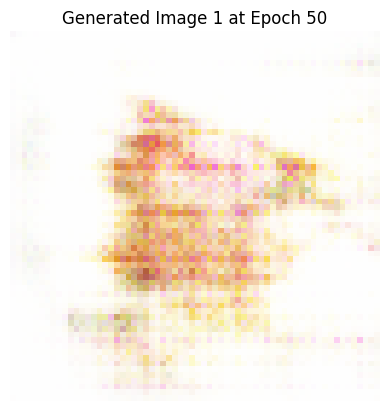

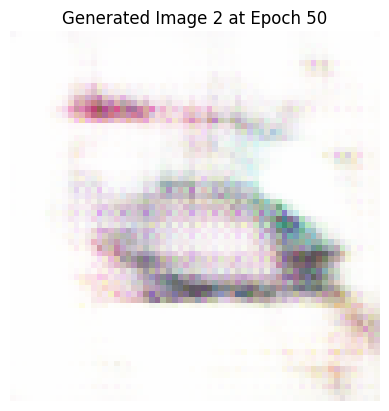

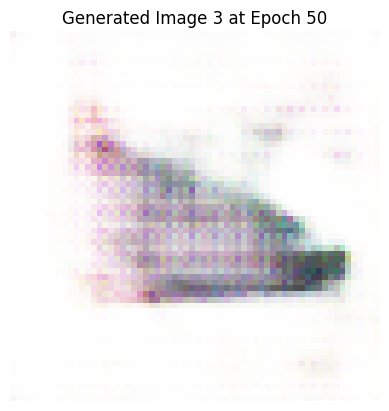

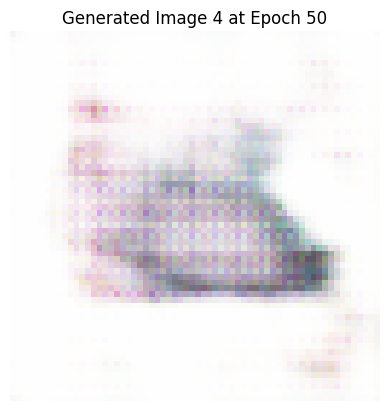

In [ ]:

def generate_and_display_images(model, captions_tensor, epoch):
    noise = tf.random.normal([len(captions_tensor), noise_dim])
    generated_images = model([noise, captions_tensor], training=False)

    for i in range(len(captions_tensor)):
        plt.figure()
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
        plt.title(f'Generated Image {i+1} at Epoch {epoch}')
        plt.show()
generate_and_display_images(generator, specific_captions_tensor, EPOCHS)

**200 epchs**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Training Parameters
BATCH_SIZE = 64
EPOCHS = 200
noise_dim = 100
BUFFER_SIZE = image_data.shape[0]

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Training step
@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)

        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Generate and display images
def generate_and_display_images(model, captions_tensor, epoch):
    noise = tf.random.normal([len(captions_tensor), noise_dim])
    generated_images = model([noise, captions_tensor], training=False)

specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
   "iPanema Women Black Flip Flops"
]

specific_captions_seq = tokenizer.texts_to_sequences(specific_captions)
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(
    specific_captions_seq,
    maxlen=max_caption_len,
    padding='post'
)
specific_captions_tensor = tf.convert_to_tensor(specific_captions_padded, dtype=tf.int32)

# Training loop
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for batch_images, batch_captions in dataset:
        g_loss, d_loss = train_step(batch_images, batch_captions)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")




Epoch 1/200
Generator Loss: 0.7636, Discriminator Loss: 1.6662

Epoch 2/200
Generator Loss: 0.6352, Discriminator Loss: 1.6980

Epoch 3/200
Generator Loss: 0.9618, Discriminator Loss: 1.4658

Epoch 4/200
Generator Loss: 1.3020, Discriminator Loss: 1.7132

Epoch 5/200
Generator Loss: 0.7368, Discriminator Loss: 1.4983

Epoch 6/200
Generator Loss: 1.3469, Discriminator Loss: 1.0091

Epoch 7/200
Generator Loss: 1.2072, Discriminator Loss: 1.8671

Epoch 8/200
Generator Loss: 0.9301, Discriminator Loss: 1.5489

Epoch 9/200
Generator Loss: 0.8061, Discriminator Loss: 1.1519

Epoch 10/200
Generator Loss: 0.6720, Discriminator Loss: 1.6712

Epoch 11/200
Generator Loss: 1.0086, Discriminator Loss: 1.3252

Epoch 12/200
Generator Loss: 0.7362, Discriminator Loss: 1.6033

Epoch 13/200
Generator Loss: 1.0067, Discriminator Loss: 1.5714

Epoch 14/200
Generator Loss: 0.7494, Discriminator Loss: 1.7072

Epoch 15/200
Generator Loss: 1.0860, Discriminator Loss: 1.3198

Epoch 16/200
Generator Loss: 1.04

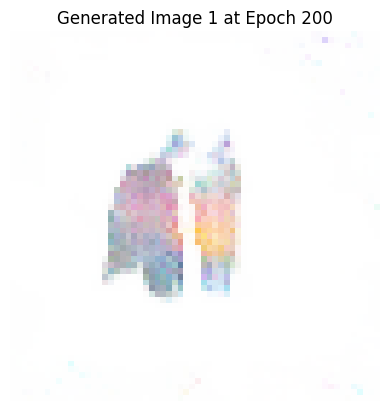

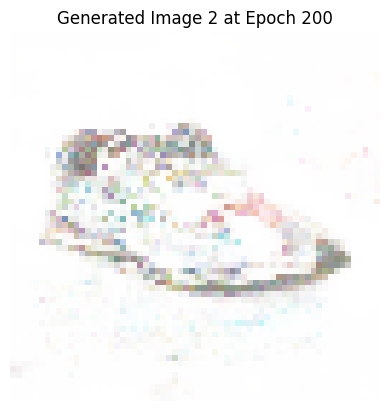

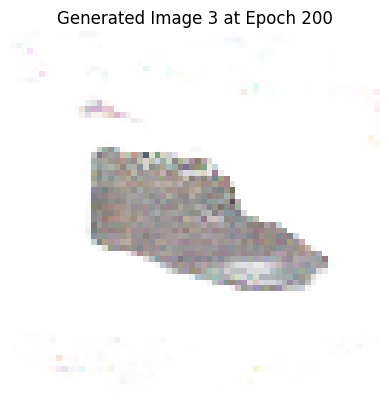

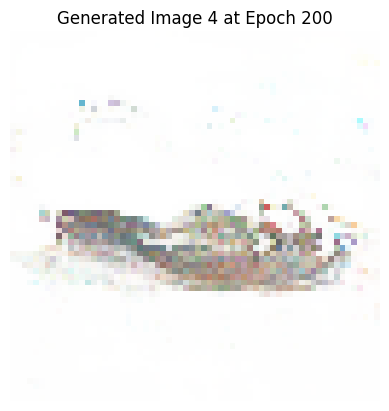

In [ ]:
# Generate and display images (separately)
def generate_and_display_images(model, captions_tensor, epoch):
    noise = tf.random.normal([len(captions_tensor), noise_dim])
    generated_images = model([noise, captions_tensor], training=False)

    for i in range(len(captions_tensor)):
        plt.figure()
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
        plt.title(f'Generated Image {i+1} at Epoch {200}')
        plt.show()
generate_and_display_images(generator, specific_captions_tensor, EPOCHS)

**600 epochs**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

# Training Parameters
BATCH_SIZE = 64
EPOCHS = 600
noise_dim = 100
BUFFER_SIZE = image_data.shape[0]

# Prepare dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

# Optimizers
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Training step
@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)

        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Generate and display images
def generate_and_display_images(model, captions_tensor, epoch):
    noise = tf.random.normal([len(captions_tensor), noise_dim])
    generated_images = model([noise, captions_tensor], training=False)

    plt.figure(figsize=(12, 4))
    for i in range(len(captions_tensor)):
        plt.subplot(1, len(captions_tensor), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
    plt.suptitle(f'Light Processed iamge'{i} 'Generated Images at Final Epoch {epoch}')
    plt.show()

specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
   "iPanema Women Black Flip Flops"
]

specific_captions_seq = tokenizer.texts_to_sequences(specific_captions)
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(
    specific_captions_seq,
    maxlen=max_caption_len,
    padding='post'
)
specific_captions_tensor = tf.convert_to_tensor(specific_captions_padded, dtype=tf.int32)

# Training loop
for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for batch_images, batch_captions in dataset:
        g_loss, d_loss = train_step(batch_images, batch_captions)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")




Epoch 1/600
Generator Loss: 2.1293, Discriminator Loss: 0.7807

Epoch 2/600
Generator Loss: 2.0728, Discriminator Loss: 0.8679

Epoch 3/600
Generator Loss: 1.7727, Discriminator Loss: 0.7895

Epoch 4/600
Generator Loss: 1.7739, Discriminator Loss: 0.6686

Epoch 5/600
Generator Loss: 2.3779, Discriminator Loss: 0.6880

Epoch 6/600
Generator Loss: 2.1615, Discriminator Loss: 0.5293

Epoch 7/600
Generator Loss: 2.4606, Discriminator Loss: 0.7467

Epoch 8/600
Generator Loss: 2.3869, Discriminator Loss: 1.3145

Epoch 9/600
Generator Loss: 1.3217, Discriminator Loss: 0.7251

Epoch 10/600
Generator Loss: 3.3132, Discriminator Loss: 0.8179

Epoch 11/600
Generator Loss: 2.3375, Discriminator Loss: 0.3154

Epoch 12/600
Generator Loss: 1.2677, Discriminator Loss: 0.5787

Epoch 13/600
Generator Loss: 0.3929, Discriminator Loss: 1.5594

Epoch 14/600
Generator Loss: 1.1700, Discriminator Loss: 0.8639

Epoch 15/600
Generator Loss: 1.3902, Discriminator Loss: 0.6003

Epoch 16/600
Generator Loss: 0.89

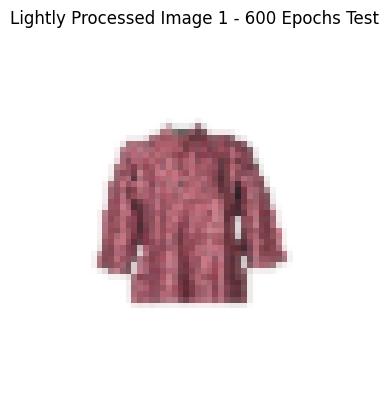

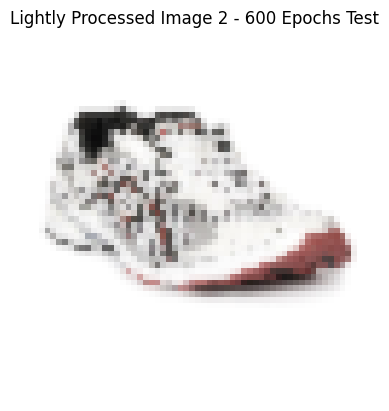

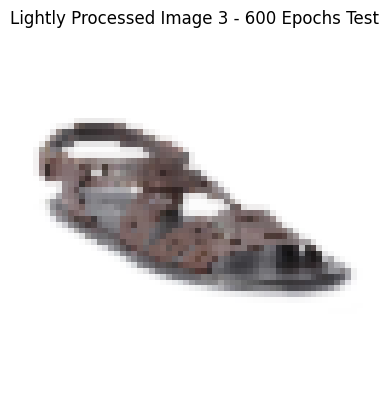

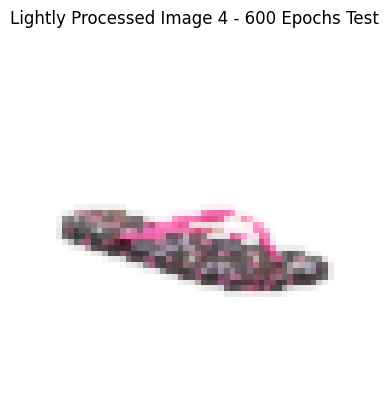

In [ ]:
# Generate and display images (separately)
def generate_and_display_images(model, captions_tensor, epoch):
    noise = tf.random.normal([len(captions_tensor), noise_dim])
    generated_images = model([noise, captions_tensor], training=False)

    for i in range(len(captions_tensor)):
        plt.figure()
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.title(f'Lightly Processed Image {i+1} - Epoch Test {600}')
        plt.axis('off')
        plt.show()
generate_and_display_images(generator, specific_captions_tensor, EPOCHS)

**FID Style**

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))
    return preprocess_input(images_resized)

def load_image(image_path, img_size=(64, 64)):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = img / 255.0
    return img

def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    real_act = model(real_images)
    gen_act = model(generated_images)

    mu1, sigma1 = np.mean(real_act, axis=0), np.cov(real_act, rowvar=False)
    mu2, sigma2 = np.mean(gen_act, axis=0), np.cov(gen_act, rowvar=False)

    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Inception Score Calculation function
def calculate_inception_score(images, splits=10):
    model = InceptionV3(include_top=True, weights='imagenet')
    images_resized = preprocess_images(images)
    preds = model(images_resized).numpy()

    scores = []
    N = preds.shape[0]
    split_size = N // splits
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * (np.log(p + 1e-10) - np.log(py + 1e-10))) for p in part])))
    return np.mean(scores), np.std(scores)

def generate_and_save_images(generator, noise, captions, epoch):
    generated_images = generator([noise, captions], training=False)


specific_captions = [
    "/kaggle/input/forrun/762maroonkurta.jpg",
    "/kaggle/input/forrun/2000white sports.jpg",
    "/kaggle/input/forrun/1500men snadals.jpg",
    "/kaggle/input/dooooo/pink flipflops.jpg"

]

specific_captions_tokenized = tokenizer.texts_to_sequences(specific_captions)
max_caption_len = 12
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(specific_captions_tokenized, maxlen=max_caption_len, padding='post')
specific_captions_padded = tf.convert_to_tensor(specific_captions_padded)

noise_dim = 100
noise = tf.random.normal([len(specific_captions), noise_dim])


# Load real images for FID evaluation
real_image_paths = [

    "/kaggle/input/forrun/762maroonkurta.jpg",
    "/kaggle/input/forrun/2000white sports.jpg",
    "/kaggle/input/forrun/1500men snadals.jpg",
    "/kaggle/input/dooooo/pink flipflops.jpg"



]


# Load real images
real_images = np.array([load_image(path) for path in real_image_paths])

# Calculate FID
fid_score = calculate_fid(real_images, generated_images)
print(f"FID Score": {fid_score:.4f})

FID Score: 8.76


# **Attention GAN**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
from datetime import datetime

# Hyperparameters
BATCH_SIZE = 64
EPOCHS = 10
noise_dim = 100
BUFFER_SIZE = image_data.shape[0]
max_caption_len = padded_captions.shape[1]
vocab_size = 1155
embedding_dim = 100
image_shape = (64, 64, 3)

# Dataset
dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

def build_text_encoder():
    caption_input = tf.keras.Input(shape=(max_caption_len,))
    x = tf.keras.layers.Embedding(vocab_size, embedding_dim)(caption_input)
    x = tf.keras.layers.LSTM(128, return_sequences=True)(x)
    attention_output = tf.keras.layers.Attention()([x, x])
    context_vector = tf.keras.layers.GlobalAveragePooling1D()(attention_output)
    return tf.keras.Model(caption_input, context_vector, name="TextEncoder")

def build_generator():
    text_encoder = build_text_encoder()
    noise_input = tf.keras.Input(shape=(noise_dim,))
    caption_input = tf.keras.Input(shape=(max_caption_len,))
    text_features = text_encoder(caption_input)
    merged = tf.keras.layers.Concatenate()([noise_input, text_features])

    x = tf.keras.layers.Dense(8*8*256, use_bias=False)(merged)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Reshape((8, 8, 256))(x)

    x = tf.keras.layers.Conv2DTranspose(128, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)

    x = tf.keras.layers.Conv2DTranspose(3, (5,5), strides=(2,2), padding='same', activation='tanh')(x)

    return tf.keras.Model([noise_input, caption_input], x, name="Generator")

def build_discriminator():
    text_encoder = build_text_encoder()
    image_input = tf.keras.Input(shape=image_shape)
    caption_input = tf.keras.Input(shape=(max_caption_len,))
    text_features = text_encoder(caption_input)
    text_features = tf.keras.layers.Dense(image_shape[0] * image_shape[1])(text_features)
    text_features = tf.keras.layers.Reshape((image_shape[0], image_shape[1], 1))(text_features)
    merged = tf.keras.layers.Concatenate()([image_input, text_features])

    x = tf.keras.layers.Conv2D(64, (5,5), strides=(2,2), padding='same')(merged)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Conv2D(128, (5,5), strides=(2,2), padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU()(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1, activation='sigmoid')(x)

    return tf.keras.Model([image_input, caption_input], x, name="Discriminator")

# Create models
generator = build_generator()
discriminator = build_discriminator()
generator.summary()
discriminator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_39            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_38            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        232,748 │ input_layer_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_27            │ (None, 228)            │              0 │ input_layer_38[0][0],  │
│ (Concatenate)             │                        │                │ TextEncoder[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 16384)          │      3,735,552 │ concatenate_27[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_865   │ (None, 16384)          │         65,536 │ dense_21[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_26            │ (None, 16384)          │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_10 (Reshape)      │ (None, 8, 8, 256)      │              0 │ leaky_re_lu_26[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_21       │ (None, 16, 16, 128)    │        819,200 │ reshape_10[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_866   │ (None, 16, 16, 128)    │            512 │ conv2d_transpose_21[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_27            │ (None, 16, 16, 128)    │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_22       │ (None, 32, 32, 64)     │        204,800 │ leaky_re_lu_27[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_867   │ (None, 32, 32, 64)     │            256 │ conv2d_transpose_22[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_28            │ (None, 32, 32, 64)     │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├──────────────────────

 Total params: 5,063,407 (19.32 MB)

 Trainable params: 5,030,255 (19.19 MB)

 Non-trainable params: 33,152 (129.50 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_42            │ (None, 12)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        232,748 │ input_layer_42[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 4096)           │        528,384 │ TextEncoder[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_41            │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_11 (Reshape)      │ (None, 64, 64, 1)      │              0 │ dense_22[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_28            │ (None, 64, 64, 4)      │              0 │ input_layer_41[0][0],  │
│ (Concatenate)             │                        │                │ reshape_11[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_854 (Conv2D)       │ (None, 32, 32, 64)     │          6,464 │ concatenate_28[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_29            │ (None, 32, 32, 64)     │              0 │ conv2d_854[0][0]       │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_855 (Conv2D)       │ (None, 16, 16, 128)    │        204,928 │ leaky_re_lu_29[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_868   │ (None, 16, 16, 128)    │            512 │ conv2d_855[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_30            │ (None, 16, 16, 128)    │              0 │ batch_normalization_8… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_4 (Flatten)       │ (None, 32768)          │              0 │ leaky_re_lu_30[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 1)              │         32,769 │ flatten_4[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,005,805 (3.84 MB)

 Trainable params: 1,005,549 (3.84 MB)

 Non-trainable params: 256 (1.00 KB)

**Training on 50**

In [ ]:
EPOCHS = 50


Epoch 1/50
Generator Loss: 7.9928, Discriminator Loss: 0.0020

Epoch 2/50
Generator Loss: 5.9565, Discriminator Loss: 0.0071

Epoch 3/50
Generator Loss: 4.6840, Discriminator Loss: 0.0410

Epoch 4/50
Generator Loss: 2.2939, Discriminator Loss: 0.3792

Epoch 5/50
Generator Loss: 2.6684, Discriminator Loss: 0.4550

Epoch 6/50
Generator Loss: 4.5118, Discriminator Loss: 0.2190

Epoch 7/50
Generator Loss: 1.9584, Discriminator Loss: 0.2765

Epoch 8/50
Generator Loss: 2.0896, Discriminator Loss: 0.2115

Epoch 9/50
Generator Loss: 0.8307, Discriminator Loss: 0.9896

Epoch 10/50
Generator Loss: 2.9962, Discriminator Loss: 0.5840

Epoch 11/50
Generator Loss: 2.3448, Discriminator Loss: 0.3677

Epoch 12/50
Generator Loss: 3.5774, Discriminator Loss: 0.6525

Epoch 13/50
Generator Loss: 2.9112, Discriminator Loss: 1.6139

Epoch 14/50
Generator Loss: 2.2363, Discriminator Loss: 0.5755

Epoch 15/50
Generator Loss: 1.3985, Discriminator Loss: 0.4944

Epoch 16/50
Generator Loss: 1.5401, Discriminato

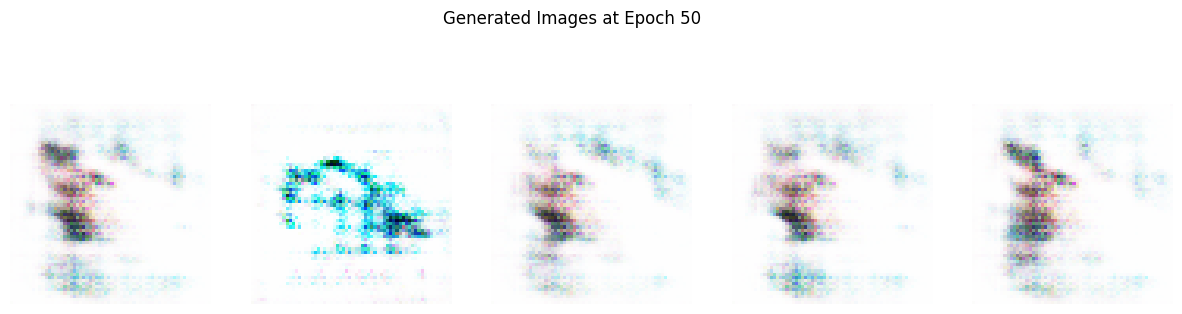

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)
        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

def generate_and_save_images(model, captions, epoch, save_dir="generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    noise = tf.random.normal([len(captions), noise_dim])
    generated_images = model([noise, captions], training=False)

    plt.figure(figsize=(15, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
        img_path = os.path.join(save_dir, f"epoch{epoch}_img{i}.png")
        plt.imsave(img_path, (generated_images[i].numpy() + 1) / 2.0)
    plt.suptitle(f'Generated Images at Epoch {epoch}')
    plt.show()

user_captions = [

    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Be Born Green Sweatshirt",
    "casual Women Beige Flats"

]

user_sequences = tokenizer.texts_to_sequences(user_captions)
user_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_caption_len, padding='post')
user_sequences_padded = tf.convert_to_tensor(user_sequences_padded)

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for image_batch, caption_batch in dataset:
        g_loss, d_loss = train_step(image_batch, caption_batch)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")

    if epoch == EPOCHS:
        generate_and_save_images(generator, user_sequences_padded, epoch)

**Training on 200**

In [ ]:
EPOCHS = 200


Epoch 1/200
Generator Loss: 0.4329, Discriminator Loss: 1.7234

Epoch 2/200
Generator Loss: 0.6948, Discriminator Loss: 1.3296

Epoch 3/200
Generator Loss: 0.8565, Discriminator Loss: 1.1915

Epoch 4/200
Generator Loss: 0.9365, Discriminator Loss: 0.9546

Epoch 5/200
Generator Loss: 1.1798, Discriminator Loss: 0.7408

Epoch 6/200
Generator Loss: 0.8135, Discriminator Loss: 1.1211

Epoch 7/200
Generator Loss: 3.6138, Discriminator Loss: 0.6788

Epoch 8/200
Generator Loss: 1.0079, Discriminator Loss: 1.4264

Epoch 9/200
Generator Loss: 3.4860, Discriminator Loss: 1.0198

Epoch 10/200
Generator Loss: 1.6140, Discriminator Loss: 1.1457

Epoch 11/200
Generator Loss: 3.5998, Discriminator Loss: 1.5144

Epoch 12/200
Generator Loss: 0.8655, Discriminator Loss: 1.2387

Epoch 13/200
Generator Loss: 1.1453, Discriminator Loss: 1.0683

Epoch 14/200
Generator Loss: 0.4002, Discriminator Loss: 1.5362

Epoch 15/200
Generator Loss: 0.8281, Discriminator Loss: 0.9561

Epoch 16/200
Generator Loss: 2.36

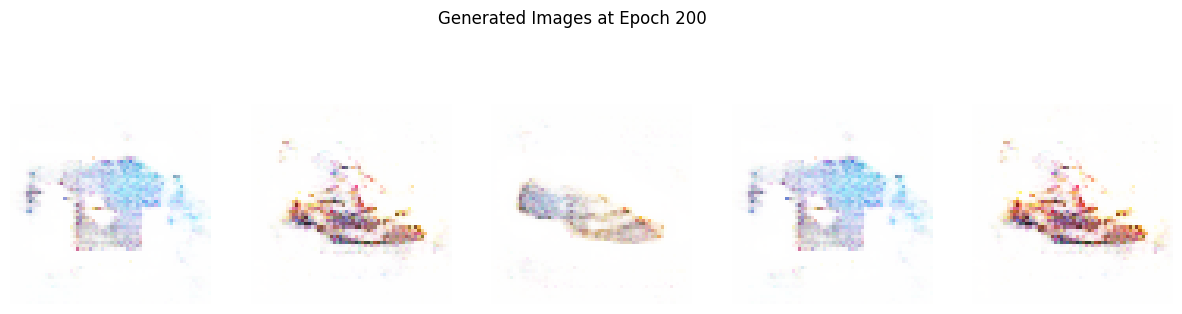

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)
        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# -----------------------------
# Image Generation
# -----------------------------

def generate_and_save_images(model, captions, epoch, save_dir="generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    noise = tf.random.normal([len(captions), noise_dim])
    generated_images = model([noise, captions], training=False)

    plt.figure(figsize=(15, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
        # Save individual image
        img_path = os.path.join(save_dir, f"epoch{epoch}_img{i}.png")
        plt.imsave(img_path, (generated_images[i].numpy() + 1) / 2.0)
    plt.suptitle(f'Generated Images at Epoch {epoch}')
    plt.show()

# -----------------------------
# Captions from User
# -----------------------------

# Define captions from user
user_captions = [

    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Be Born Green Sweatshirt",
    "casual Women Beige Flats"

]

user_sequences = tokenizer.texts_to_sequences(user_captions)
user_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_caption_len, padding='post')
user_sequences_padded = tf.convert_to_tensor(user_sequences_padded)

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for image_batch, caption_batch in dataset:
        g_loss, d_loss = train_step(image_batch, caption_batch)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")

    if epoch == EPOCHS:
        generate_and_save_images(generator, user_sequences_padded, epoch)

**TRaing on 600**

In [ ]:
EPOCHS = 600


Epoch 1/600
Generator Loss: 3.1684, Discriminator Loss: 0.1326

Epoch 2/600
Generator Loss: 2.1867, Discriminator Loss: 0.2906

Epoch 3/600
Generator Loss: 2.0382, Discriminator Loss: 0.1800

Epoch 4/600
Generator Loss: 4.6644, Discriminator Loss: 0.8885

Epoch 5/600
Generator Loss: 2.0164, Discriminator Loss: 0.2932

Epoch 6/600
Generator Loss: 1.9290, Discriminator Loss: 0.2340

Epoch 7/600
Generator Loss: 0.8305, Discriminator Loss: 0.7518

Epoch 8/600
Generator Loss: 3.5726, Discriminator Loss: 0.1102

Epoch 9/600
Generator Loss: 3.0726, Discriminator Loss: 0.2153

Epoch 10/600
Generator Loss: 2.2260, Discriminator Loss: 0.1675

Epoch 11/600
Generator Loss: 1.8400, Discriminator Loss: 0.2387

Epoch 12/600
Generator Loss: 3.8066, Discriminator Loss: 1.1125

Epoch 13/600
Generator Loss: 2.6458, Discriminator Loss: 0.3396

Epoch 14/600
Generator Loss: 1.9008, Discriminator Loss: 0.2531

Epoch 15/600
Generator Loss: 0.5532, Discriminator Loss: 0.9510

Epoch 16/600
Generator Loss: 2.49

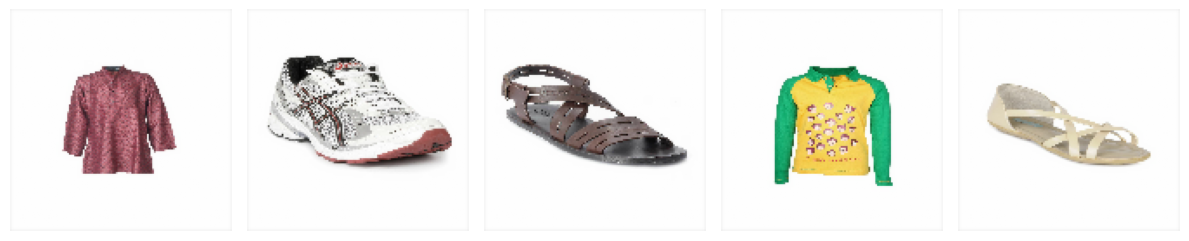

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)
        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def generate_and_save_images(model, captions, epoch, save_dir="generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    noise = tf.random.normal([len(captions), noise_dim])
    generated_images = model([noise, captions], training=False)

    plt.figure(figsize=(15, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
        # Save individual image
        img_path = os.path.join(save_dir, f"epoch{epoch}_img{i}.png")
        plt.imsave(img_path, (generated_images[i].numpy() + 1) / 2.0)
    plt.suptitle(f'Generated Images at Epoch {epoch}')
    plt.show()

# Define captions from user
user_captions = [

    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Be Born Green Sweatshirt",
    "casual Women Beige Flats"

]


user_sequences = tokenizer.texts_to_sequences(user_captions)
user_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_caption_len, padding='post')
user_sequences_padded = tf.convert_to_tensor(user_sequences_padded)


for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for image_batch, caption_batch in dataset:
        g_loss, d_loss = train_step(image_batch, caption_batch)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")

    if epoch == EPOCHS:
        generate_and_save_images(generator, user_sequences_padded, epoch)

**Experiment On Random Caption**

In [ ]:
EPOCHS=600


Epoch 1/600
Generator Loss: 0.5424, Discriminator Loss: 1.7880

Epoch 2/600
Generator Loss: 0.5030, Discriminator Loss: 1.8117

Epoch 3/600
Generator Loss: 0.7318, Discriminator Loss: 2.5752

Epoch 4/600
Generator Loss: 0.8738, Discriminator Loss: 1.4964

Epoch 5/600
Generator Loss: 1.9847, Discriminator Loss: 1.4574

Epoch 6/600
Generator Loss: 1.0341, Discriminator Loss: 1.3859

Epoch 7/600
Generator Loss: 1.1156, Discriminator Loss: 0.7929

Epoch 8/600
Generator Loss: 0.6837, Discriminator Loss: 1.4728

Epoch 9/600
Generator Loss: 0.7756, Discriminator Loss: 1.6916

Epoch 10/600
Generator Loss: 0.7428, Discriminator Loss: 1.4537

Epoch 11/600
Generator Loss: 0.5370, Discriminator Loss: 1.4774

Epoch 12/600
Generator Loss: 0.8797, Discriminator Loss: 1.0589

Epoch 13/600
Generator Loss: 0.8876, Discriminator Loss: 1.5716

Epoch 14/600
Generator Loss: 1.0187, Discriminator Loss: 1.5155

Epoch 15/600
Generator Loss: 0.7223, Discriminator Loss: 1.4943

Epoch 16/600
Generator Loss: 0.59

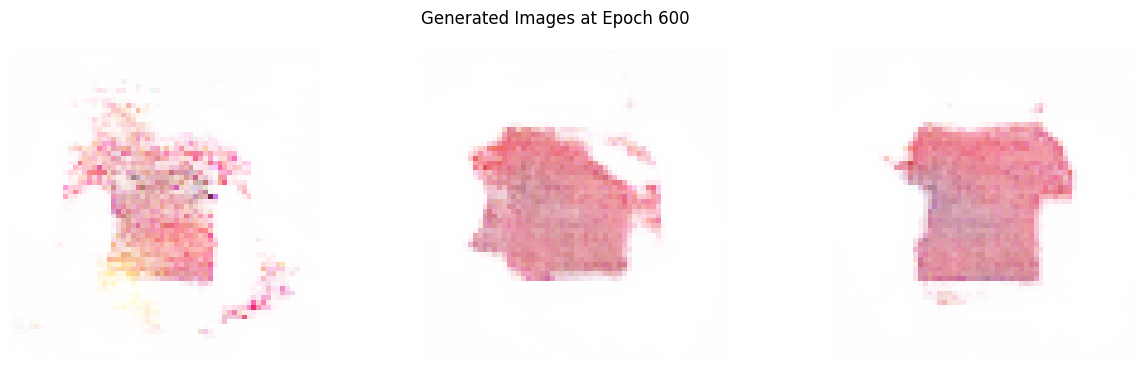

In [ ]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

@tf.function
def train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator([noise, captions], training=True)
        real_output = discriminator([images, captions], training=True)
        fake_output = discriminator([generated_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


def generate_and_save_images(model, captions, epoch, save_dir="generated_images"):
    os.makedirs(save_dir, exist_ok=True)
    noise = tf.random.normal([len(captions), noise_dim])
    generated_images = model([noise, captions], training=False)

    plt.figure(figsize=(15, 4))
    for i in range(len(captions)):
        plt.subplot(1, len(captions), i+1)
        plt.imshow((generated_images[i].numpy() + 1) / 2.0)
        plt.axis('off')
        img_path = os.path.join(save_dir, f"epoch{epoch}_img{i}.png")
        plt.imsave(img_path, (generated_images[i].numpy() + 1) / 2.0)
    plt.suptitle(f'Generated Images at Epoch {epoch}')
    plt.show()

user_captions = [

    "a red balloon in the sky",
    "a glass of orange juice",
    "a firetruck on the road",


]

# Tokenize and pad
user_sequences = tokenizer.texts_to_sequences(user_captions)
user_sequences_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_caption_len, padding='post')
user_sequences_padded = tf.convert_to_tensor(user_sequences_padded)

# -----------------------------
# Training Loop
# -----------------------------

for epoch in range(1, EPOCHS + 1):
    print(f"\nEpoch {epoch}/{EPOCHS}")
    for image_batch, caption_batch in dataset:
        g_loss, d_loss = train_step(image_batch, caption_batch)

    print(f"Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")

    if epoch == EPOCHS:
        generate_and_save_images(generator, user_sequences_padded, epoch)

**FID aTTENTION**

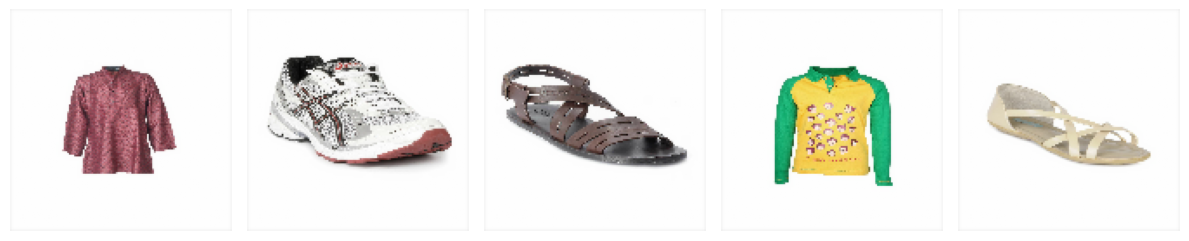

FID Score: 5.986


In [ ]:



import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

# Function to preprocess images for InceptionV3 (resize to 299x299 and normalize)
def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))  # Resize to 299x299 for InceptionV3
    return preprocess_input(images_resized)  # Preprocess images for InceptionV3

# Function to load and preprocess a single image (real or generated)
def load_image(image_path, img_size=(64, 64)):
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_jpeg(img, channels=3)  # Decode as JPEG
    img = tf.image.resize(img, img_size)  # Resize to the input size (64x64 for this case)
    img = img / 255.0  # Normalize the image to [0, 1]
    return img

# FID Calculation function
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Preprocess images
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Extract features (activations) from InceptionV3
    real_act = model(real_images)
    gen_act = model(generated_images)

    # Calculate the mean and covariance of activations
    mu1, sigma1 = np.mean(real_act, axis=0), np.cov(real_act, rowvar=False)
    mu2, sigma2 = np.mean(gen_act, axis=0), np.cov(gen_act, rowvar=False)

    # Calculate the FID score
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    # Check if the sqrtm produces complex values, and take the real part if necessary
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Inception Score Calculation function
def calculate_inception_score(images, splits=10):
    model = InceptionV3(include_top=True, weights='imagenet')
    images_resized = preprocess_images(images)
    preds = model(images_resized).numpy()

    scores = []
    N = preds.shape[0]
    split_size = N // splits
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * (np.log(p + 1e-10) - np.log(py + 1e-10))) for p in part])))
    return np.mean(scores), np.std(scores)

# Function to generate images
def generate_and_save_images(generator, noise, captions, epoch):
    generated_images = generator([noise, captions], training=False)


# Tokenizing and padding captions
specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Expressions Yellow T-shirt"
]

# Assuming tokenizer and max_caption_len are already defined (as per your training code)
specific_captions_tokenized = tokenizer.texts_to_sequences(specific_captions)
max_caption_len = 12  # Set based on your padding length
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(specific_captions_tokenized, maxlen=max_caption_len, padding='post')
specific_captions_padded = tf.convert_to_tensor(specific_captions_padded)

# Assuming noise_dim is defined and generator is your trained model
noise_dim = 100  # Adjust based on your model's noise dimension
noise = tf.random.normal([len(specific_captions), noise_dim])
# Generate images from the generator
generated_images = generator([noise, specific_captions_padded], training=False)

generate_and_save_images(generator, noise, specific_captions_padded, epoch=1)

real_image_paths = [
    '/kaggle/input/iamgestotest/762maroonkurta.jpg',
    '/kaggle/input/iamgestotest/2000white sports.jpg',
    '/kaggle/input/iamgestotest/1500men snadals.jpg',
    '/kaggle/input/iamgestotest/1208shirtsmarvel.jpg'
]

# Load real images
real_images = np.array([load_image(path) for path in real_image_paths])


fid_score = calculate_fid(real_images, generated_images)
print (f"FID Score": {fid_score:.4f})


# **Stack Gan**

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Embedding, LSTM, Concatenate, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D
from tensorflow.keras.models import Model

# Parameters
vocab_size = 1155
max_caption_len = 12
embedding_dim = 100
noise_dim = 100
image_shape_stage1 = (64, 64, 3)
image_shape_stage2 = (128, 128, 3)

# ------------------------------
# Text Encoder
def build_text_encoder():
    caption_input = Input(shape=(max_caption_len,))
    x = Embedding(vocab_size, embedding_dim)(caption_input)
    x = LSTM(128)(x)
    return Model(caption_input, x, name="TextEncoder")

text_encoder = build_text_encoder()

# ------------------------------
# Generator - Stage I
def build_stage1_generator():
    noise_input = Input(shape=(noise_dim,))
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    merged = Concatenate()([noise_input, text_features])

    x = Dense(8 * 8 * 256, use_bias=False)(merged)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    return Model([noise_input, caption_input], x, name="Stage1Generator")

# ------------------------------
# Discriminator - Stage I
def build_stage1_discriminator():
    image_input = Input(shape=image_shape_stage1)
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    text_features = Dense(64 * 64)(text_features)
    text_features = Reshape((64, 64, 1))(text_features)

    merged = Concatenate()([image_input, text_features])

    x = Conv2D(64, 4, strides=2, padding='same')(merged)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model([image_input, caption_input], x, name="Stage1Discriminator")


def build_stage2_generator(stage1_generator):
    noise_input = Input(shape=(noise_dim,))
    caption_input = Input(shape=(max_caption_len,))

    stage1_image = stage1_generator([noise_input, caption_input])

    x = Conv2D(64, 3, padding='same', activation='relu')(stage1_image)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    output = Conv2D(3, 3, padding='same', activation='tanh')(x)
    return Model([noise_input, caption_input], output, name="Stage2Generator")

def build_stage2_discriminator():
    image_input = Input(shape=image_shape_stage2)
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    text_features = Dense(128 * 128)(text_features)
    text_features = Reshape((128, 128, 1))(text_features)

    merged = Concatenate()([image_input, text_features])

    x = Conv2D(64, 4, strides=2, padding='same')(merged)
    x = LeakyReLU()(x)

    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model([image_input, caption_input], x, name="Stage2Discriminator")


stage1_gen = build_stage1_generator()
stage1_disc = build_stage1_discriminator()
stage2_gen = build_stage2_generator(stage1_gen)
stage2_disc = build_stage2_discriminator()

stage1_gen.summary()
stage1_disc.summary()
stage2_gen.summary()
stage2_disc.summary()





Model: "Stage1Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_38            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_37            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        362,848 │ input_layer_38[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_12            │ (None, 228)            │              0 │ input_layer_37[0][0],  │
│ (Concatenate)             │                        │                │ TextEncoder[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_20 (Dense)          │ (None, 16384)          │      3,735,552 │ concatenate_12[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_32    │ (None, 16384)          │         65,536 │ dense_20[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_36            │ (None, 16384)          │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_12 (Reshape)      │ (None, 8, 8, 256)      │              0 │ leaky_re_lu_36[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_20       │ (None, 16, 16, 128)    │        524,288 │ reshape_12[0][0]       │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_33    │ (None, 16, 16, 128)    │            512 │ conv2d_transpose_20[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_37            │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_21       │ (None, 32, 32, 64)     │        131,072 │ leaky_re_lu_37[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_34    │ (None, 32, 32, 64)     │            256 │ conv2d_transpose_21[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_38            │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├──────────────────────

 Total params: 4,823,139 (18.40 MB)

 Trainable params: 4,789,987 (18.27 MB)

 Non-trainable params: 33,152 (129.50 KB)

Model: "Stage1Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_40            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        362,848 │ input_layer_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_21 (Dense)          │ (None, 4096)           │        528,384 │ TextEncoder[1][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_39            │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_13 (Reshape)      │ (None, 64, 64, 1)      │              0 │ dense_21[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_13            │ (None, 64, 64, 4)      │              0 │ input_layer_39[0][0],  │
│ (Concatenate)             │                        │                │ reshape_13[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_24 (Conv2D)        │ (None, 32, 32, 64)     │          4,160 │ concatenate_13[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_39            │ (None, 32, 32, 64)     │              0 │ conv2d_24[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_25 (Conv2D)        │ (None, 16, 16, 128)    │        131,200 │ leaky_re_lu_39[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_35    │ (None, 16, 16, 128)    │            512 │ conv2d_25[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_40            │ (None, 16, 16, 128)    │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_8 (Flatten)       │ (None, 32768)          │              0 │ leaky_re_lu_40[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_22 (Dense)          │ (None, 1)              │         32,769 │ flatten_8[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,059,873 (4.04 MB)

 Trainable params: 1,059,617 (4.04 MB)

 Non-trainable params: 256 (1.00 KB)

Model: "Stage2Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_41            │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_42            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ Stage1Generator           │ (None, 64, 64, 3)      │      4,823,139 │ input_layer_41[0][0],  │
│ (Functional)              │                        │                │ input_layer_42[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_26 (Conv2D)        │ (None, 64, 64, 64)     │          1,792 │ Stage1Generator[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 64, 64, 64)     │            256 │ conv2d_26[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_23       │ (None, 128, 128, 128)  │        131,200 │ batch_normalization_3… │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 128, 128, 128)  │            512 │ conv2d_transpose_23[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_41            │ (None, 128, 128, 128)  │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_24       │ (None, 256, 256, 64)   │        131,136 │ leaky_re_lu_41[0][0]   │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 256, 256, 64)   │            256 │ conv2d_transpose_24[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_42            │ (None, 256, 256, 64)   │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_27 (Conv2D)        │ (None, 256, 256, 3)    │          1,731 │ leaky_re_lu_42[0][0]   │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 5,090,022 (19.42 MB)

 Trainable params: 5,056,358 (19.29 MB)

 Non-trainable params: 33,664 (131.50 KB)

Model: "Stage2Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_44            │ (None, 13)             │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ TextEncoder (Functional)  │ (None, 128)            │        362,848 │ input_layer_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_23 (Dense)          │ (None, 16384)          │      2,113,536 │ TextEncoder[2][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_43            │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_14 (Reshape)      │ (None, 128, 128, 1)    │              0 │ dense_23[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ concatenate_14            │ (None, 128, 128, 4)    │              0 │ input_layer_43[0][0],  │
│ (Concatenate)             │                        │                │ reshape_14[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_28 (Conv2D)        │ (None, 64, 64, 64)     │          4,160 │ concatenate_14[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_43            │ (None, 64, 64, 64)     │              0 │ conv2d_28[0][0]        │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_29 (Conv2D)        │ (None, 32, 32, 128)    │        131,200 │ leaky_re_lu_43[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 32, 32, 128)    │            512 │ conv2d_29[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ leaky_re_lu_44            │ (None, 32, 32, 128)    │              0 │ batch_normalization_3… │
│ (LeakyReLU)               │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_9 (Flatten)       │ (None, 131072)         │              0 │ leaky_re_lu_44[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_24 (Dense)          │ (None, 1)              │        131,073 │ flatten_9[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,743,329 (10.46 MB)

 Trainable params: 2,743,073 (10.46 MB)

 Non-trainable params: 256 (1.00 KB)

**Training 10**

In [ ]:
BATCH_SIZE = 64
EPOCHS = 10
BUFFER_SIZE = image_data.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

@tf.function
def stage1_train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = stage1_gen([noise, captions], training=True)
        real_output = stage1_disc([images, captions], training=True)
        fake_output = stage1_disc([fake_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, stage1_gen.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, stage1_disc.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_gen, stage1_gen.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_disc, stage1_disc.trainable_variables))
    return gen_loss, disc_loss

@tf.function
def stage2_train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        high_res_fake = stage2_gen([noise, captions], training=True)
        real_output = stage2_disc([images, captions], training=True)
        fake_output = stage2_disc([high_res_fake, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, stage2_gen.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, stage2_disc.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_gen, stage2_gen.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_disc, stage2_disc.trainable_variables))
    return gen_loss, disc_loss


In [ ]:

print("\nStarting Stage-I Training...")
for epoch in range(1, EPOCHS + 1):
    for images, captions in dataset:
        g_loss, d_loss = stage1_train_step(images, captions)
    print(f"[Stage I] Epoch {epoch}/{EPOCHS} - Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


Starting Stage-I Training...
[Stage I] Epoch 1/10 - Generator Loss: 1.4960, Discriminator Loss: 0.6836
[Stage I] Epoch 2/10 - Generator Loss: 1.7610, Discriminator Loss: 0.8305
[Stage I] Epoch 3/10 - Generator Loss: 1.7350, Discriminator Loss: 0.7446
[Stage I] Epoch 4/10 - Generator Loss: 1.8204, Discriminator Loss: 0.8028
[Stage I] Epoch 5/10 - Generator Loss: 1.6209, Discriminator Loss: 0.7308
[Stage I] Epoch 6/10 - Generator Loss: 0.8928, Discriminator Loss: 0.9224
[Stage I] Epoch 7/10 - Generator Loss: 1.2337, Discriminator Loss: 0.7256
[Stage I] Epoch 8/10 - Generator Loss: 2.1988, Discriminator Loss: 0.8554
[Stage I] Epoch 9/10 - Generator Loss: 1.5070, Discriminator Loss: 0.6248
[Stage I] Epoch 10/10 - Generator Loss: 1.0415, Discriminator Loss: 0.9595


In [ ]:
# ------------------------------
# Stage II Training Loop
print("\nStarting Stage-II Training...")
for epoch in range(1, EPOCHS + 1):
    for images, captions in dataset:
        g_loss, d_loss = stage1_train_step(images, captions)
    print(f"[Stage II] Epoch {epoch}/{EPOCHS} - Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


Starting Stage-II Training...
[Stage II] Epoch 1/10 - Generator Loss: 2.0432, Discriminator Loss: 0.6594
[Stage II] Epoch 2/10 - Generator Loss: 1.1412, Discriminator Loss: 0.7785
[Stage II] Epoch 3/10 - Generator Loss: 1.1306, Discriminator Loss: 0.6802
[Stage II] Epoch 4/10 - Generator Loss: 1.1629, Discriminator Loss: 0.7856
[Stage II] Epoch 5/10 - Generator Loss: 1.0672, Discriminator Loss: 0.9019
[Stage II] Epoch 6/10 - Generator Loss: 2.2695, Discriminator Loss: 0.3253
[Stage II] Epoch 7/10 - Generator Loss: 2.3817, Discriminator Loss: 0.4596
[Stage II] Epoch 8/10 - Generator Loss: 3.2227, Discriminator Loss: 0.3023
[Stage II] Epoch 9/10 - Generator Loss: 1.5374, Discriminator Loss: 1.5709
[Stage II] Epoch 10/10 - Generator Loss: 1.4896, Discriminator Loss: 0.8740


**Genearte iamge**

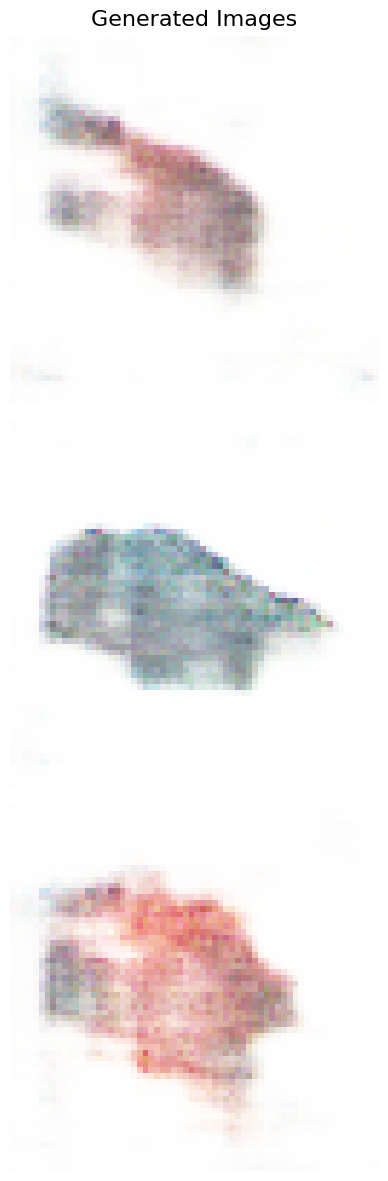

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_from_caption(caption, tokenizer, stage2_gen, max_caption_len, noise_dim=100):
    # Preprocess caption
    tokens = tokenizer.texts_to_sequences([caption])
    padded_caption = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen=max_caption_len, padding='post')

    # Convert to tensor
    padded_caption = tf.convert_to_tensor(padded_caption)

    # Generate random noise
    noise = tf.random.normal([1, noise_dim])

    # Generate image
    generated_image = stage2_gen([noise, padded_caption], training=False)[0].numpy()

    # Scale image from [-1, 1] to [0, 1]
    generated_image = (generated_image + 1) / 2.0

    plt.imshow(generated_image)
    plt.axis('off')
    plt.title("Generated Image")
    plt.show()
test_caption = "casual Boys white Printed T-Shirt"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)
test_caption = "Men Dark Brown Formal Shoes"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)
test_caption = "Girl's Pink White Check Top Kidswear"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)


**train 200**

In [ ]:

# Training Setup
BATCH_SIZE = 64
EPOCHS = 200
BUFFER_SIZE = image_data.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# ------------------------------
# Stage I Training Step
@tf.function
def stage1_train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = stage1_gen([noise, captions], training=True)
        real_output = stage1_disc([images, captions], training=True)
        fake_output = stage1_disc([fake_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, stage1_gen.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, stage1_disc.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_gen, stage1_gen.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_disc, stage1_disc.trainable_variables))
    return gen_loss, disc_loss
# ------------------------------
# Stage II Training Step
@tf.function
def stage2_train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        high_res_fake = stage2_gen([noise, captions], training=True)
        real_output = stage2_disc([images, captions], training=True)
        fake_output = stage2_disc([high_res_fake, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, stage2_gen.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, stage2_disc.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_gen, stage2_gen.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_disc, stage2_disc.trainable_variables))
    return gen_loss, disc_loss


In [ ]:
# ------------------------------
# Stage I Training Loop
print("\nStarting Stage-I Training...")
for epoch in range(1, EPOCHS + 1):
    for images, captions in dataset:
        g_loss, d_loss = stage1_train_step(images, captions)
    print(f"[Stage I] Epoch {epoch}/{EPOCHS} - Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


Starting Stage-I Training...
[Stage I] Epoch 1/200 - Generator Loss: 1.2668, Discriminator Loss: 1.0716
[Stage I] Epoch 2/200 - Generator Loss: 1.2805, Discriminator Loss: 0.8660
[Stage I] Epoch 3/200 - Generator Loss: 1.0355, Discriminator Loss: 0.6909
[Stage I] Epoch 4/200 - Generator Loss: 1.5762, Discriminator Loss: 0.8945
[Stage I] Epoch 5/200 - Generator Loss: 1.9195, Discriminator Loss: 0.4964
[Stage I] Epoch 6/200 - Generator Loss: 0.4976, Discriminator Loss: 1.2670
[Stage I] Epoch 7/200 - Generator Loss: 0.9580, Discriminator Loss: 1.0622
[Stage I] Epoch 8/200 - Generator Loss: 2.1180, Discriminator Loss: 0.6408
[Stage I] Epoch 9/200 - Generator Loss: 2.7262, Discriminator Loss: 1.3397
[Stage I] Epoch 10/200 - Generator Loss: 1.1245, Discriminator Loss: 0.8286
[Stage I] Epoch 11/200 - Generator Loss: 1.8733, Discriminator Loss: 0.4976
[Stage I] Epoch 12/200 - Generator Loss: 1.4021, Discriminator Loss: 0.5740
[Stage I] Epoch 13/200 - Generator Loss: 1.1123, Discriminator Loss

In [ ]:
# ------------------------------
# Stage II Training Loop
print("\nStarting Stage-II Training...")
for epoch in range(1, EPOCHS + 1):
    for images, captions in dataset:
        g_loss, d_loss = stage1_train_step(images, captions)
    print(f"[Stage II] Epoch {epoch}/{EPOCHS} - Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


Starting Stage-II Training...
[Stage II] Epoch 1/200 - Generator Loss: 1.9020, Discriminator Loss: 0.3043
[Stage II] Epoch 2/200 - Generator Loss: 1.7810, Discriminator Loss: 0.4168
[Stage II] Epoch 3/200 - Generator Loss: 1.6862, Discriminator Loss: 0.4737
[Stage II] Epoch 4/200 - Generator Loss: 2.4689, Discriminator Loss: 0.3401
[Stage II] Epoch 5/200 - Generator Loss: 2.0730, Discriminator Loss: 0.3467
[Stage II] Epoch 6/200 - Generator Loss: 2.1639, Discriminator Loss: 0.4367
[Stage II] Epoch 7/200 - Generator Loss: 2.3233, Discriminator Loss: 0.3839
[Stage II] Epoch 8/200 - Generator Loss: 2.2741, Discriminator Loss: 0.4216
[Stage II] Epoch 9/200 - Generator Loss: 1.9114, Discriminator Loss: 0.5414
[Stage II] Epoch 10/200 - Generator Loss: 0.7721, Discriminator Loss: 0.8792
[Stage II] Epoch 11/200 - Generator Loss: 1.7164, Discriminator Loss: 0.3862
[Stage II] Epoch 12/200 - Generator Loss: 1.6809, Discriminator Loss: 0.4130
[Stage II] Epoch 13/200 - Generator Loss: 2.5502, Disc

**Image Geneartion**

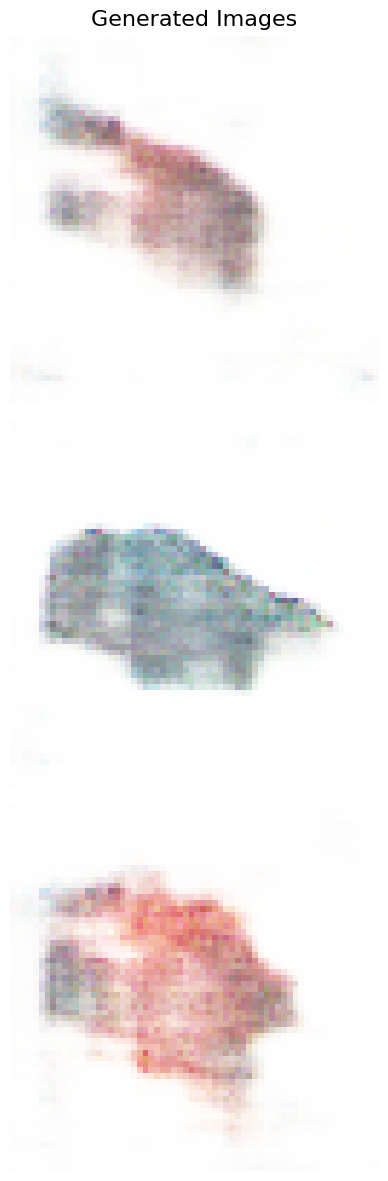

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_from_caption(caption, tokenizer, stage2_gen, max_caption_len, noise_dim=100):
    # Preprocess caption
    tokens = tokenizer.texts_to_sequences([caption])
    padded_caption = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen=max_caption_len, padding='post')

    # Convert to tensor
    padded_caption = tf.convert_to_tensor(padded_caption)

    # Generate random noise
    noise = tf.random.normal([1, noise_dim])

    # Generate image
    generated_image = stage2_gen([noise, padded_caption], training=False)[0].numpy()

    # Scale image from [-1, 1] to [0, 1]
    generated_image = (generated_image + 1) / 2.0

    plt.imshow(generated_image)
    plt.axis('off')
    plt.title("Generated Image")
    plt.show()
test_caption = "casual Boys white Printed T-Shirt"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)
test_caption = "Men Dark Brown Formal Shoes"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)
test_caption = "Girl's Pink White Check Top Kidswear"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)


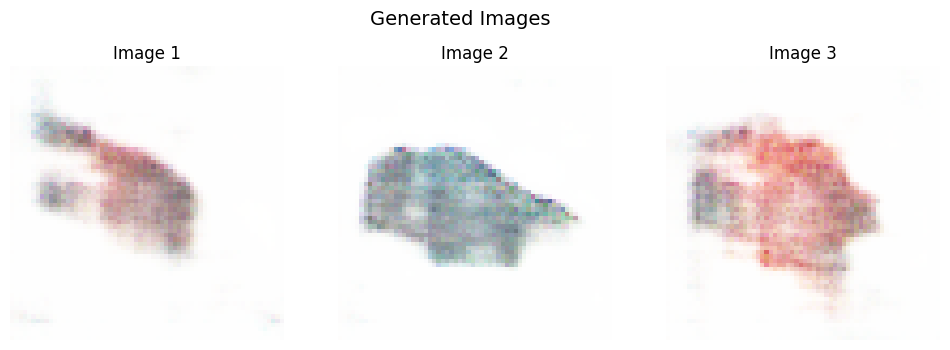

FID Score: 55.012


In [ ]:



import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3, preprocess_input
from scipy.linalg import sqrtm
import matplotlib.pyplot as plt

# Function to preprocess images for InceptionV3 (resize to 299x299 and normalize)
def preprocess_images(images):
    images_resized = tf.image.resize(images, (299, 299))  # Resize to 299x299 for InceptionV3
    return preprocess_input(images_resized)  # Preprocess images for InceptionV3

# Function to load and preprocess a single image (real or generated)
def load_image(image_path, img_size=(64, 64)):
    img = tf.io.read_file(image_path)  # Read the image file
    img = tf.image.decode_jpeg(img, channels=3)  # Decode as JPEG
    img = tf.image.resize(img, img_size)  # Resize to the input size (64x64 for this case)
    img = img / 255.0  # Normalize the image to [0, 1]
    return img

# FID Calculation function
def calculate_fid(real_images, generated_images):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299, 299, 3))

    # Preprocess images
    real_images = preprocess_images(real_images)
    generated_images = preprocess_images(generated_images)

    # Extract features (activations) from InceptionV3
    real_act = model(real_images)
    gen_act = model(generated_images)

    # Calculate the mean and covariance of activations
    mu1, sigma1 = np.mean(real_act, axis=0), np.cov(real_act, rowvar=False)
    mu2, sigma2 = np.mean(gen_act, axis=0), np.cov(gen_act, rowvar=False)

    # Calculate the FID score
    ssdiff = np.sum((mu1 - mu2) ** 2.0)
    covmean, _ = sqrtm(sigma1.dot(sigma2), disp=False)

    # Check if the sqrtm produces complex values, and take the real part if necessary
    if np.iscomplexobj(covmean):
        covmean = covmean.real

    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

# Inception Score Calculation function
def calculate_inception_score(images, splits=10):
    model = InceptionV3(include_top=True, weights='imagenet')
    images_resized = preprocess_images(images)
    preds = model(images_resized).numpy()

    scores = []
    N = preds.shape[0]
    split_size = N // splits
    for i in range(splits):
        part = preds[i * split_size: (i + 1) * split_size]
        py = np.mean(part, axis=0)
        scores.append(np.exp(np.mean([np.sum(p * (np.log(p + 1e-10) - np.log(py + 1e-10))) for p in part])))
    return np.mean(scores), np.std(scores)

# Function to generate images
def generate_and_save_images(generator, noise, captions, epoch):
    generated_images = generator([noise, captions], training=False)


# Tokenizing and padding captions
specific_captions = [
    "ethnic Boys Printed Maroon Kurta",
    "sports Men Gel Running White Sports Shoes",
    "casual Men Aventura Sandal",
    "casual Boys Expressions Yellow T-shirt"
]

# Assuming tokenizer and max_caption_len are already defined (as per your training code)
specific_captions_tokenized = tokenizer.texts_to_sequences(specific_captions)
max_caption_len = 12  # Set based on your padding length
specific_captions_padded = tf.keras.preprocessing.sequence.pad_sequences(specific_captions_tokenized, maxlen=max_caption_len, padding='post')
specific_captions_padded = tf.convert_to_tensor(specific_captions_padded)

# Assuming noise_dim is defined and generator is your trained model
noise_dim = 100  # Adjust based on your model's noise dimension
noise = tf.random.normal([len(specific_captions), noise_dim])  # Generate random noise for each caption

# Generate images from the generator
generated_images = generator([noise, specific_captions_padded], training=False)

# Display the generated images
generate_and_save_images(generator, noise, specific_captions_padded, epoch=1)

# Load real images for FID evaluation
real_image_paths = [
    '/kaggle/input/iamgestotest/762maroonkurta.jpg',  # Replace with your actual file paths
    '/kaggle/input/iamgestotest/2000white sports.jpg',
    '/kaggle/input/iamgestotest/1500men snadals.jpg',
    '/kaggle/input/iamgestotest/1208shirtsmarvel.jpg'
]

# Load real images
real_images = np.array([load_image(path) for path in real_image_paths])

# Calculate FID
fid_score = calculate_fid(real_images, generated_images)
print (f"FID Score": {fid_score:.4f})


**Hyperparameters tune**

Excellent — your dual-stage text-to-image GAN model is now structurally complete with:

✅ 256x256 resolution
✅ Improved LSTM and dropout
✅ Upsampling
✅ Learning rate scheduler
✅ Loss functions

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import (Input, Dense, Reshape, Flatten, Embedding, LSTM, Dropout,
                                     Concatenate, BatchNormalization, LeakyReLU, Conv2DTranspose, Conv2D)
from tensorflow.keras.models import Model

# Parameters
vocab_size = 1155
max_caption_len = 12
embedding_dim = 100
noise_dim = 100
image_shape_stage1 = (64, 64, 3)
image_shape_stage2 = (256, 256, 3)

# Text Encoder
def build_text_encoder():
    caption_input = Input(shape=(max_caption_len,))
    x = Embedding(vocab_size, embedding_dim)(caption_input)
    x = LSTM(512)(x)
    x = Dropout(0.5)(x)
    return Model(caption_input, x, name="TextEncoder")

text_encoder = build_text_encoder()

# Stage I Generator
def build_stage1_generator():
    noise_input = Input(shape=(noise_dim,))
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    merged = Concatenate()([noise_input, text_features])

    x = Dense(8 * 8 * 256, use_bias=False)(merged)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Reshape((8, 8, 256))(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 4, strides=2, padding='same', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)

    return Model([noise_input, caption_input], x, name="Stage1Generator")

# Stage I Discriminator
def build_stage1_discriminator():
    image_input = Input(shape=image_shape_stage1)
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    text_features = Dense(64 * 64)(text_features)
    text_features = Reshape((64, 64, 1))(text_features)

    merged = Concatenate()([image_input, text_features])

    x = Conv2D(64, 4, strides=2, padding='same')(merged)
    x = LeakyReLU()(x)
    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model([image_input, caption_input], x, name="Stage1Discriminator")

# Stage II Generator (256x256)
def build_stage2_generator(stage1_generator):
    noise_input = Input(shape=(noise_dim,))
    caption_input = Input(shape=(max_caption_len,))

    stage1_image = stage1_generator([noise_input, caption_input])

    x = Conv2D(64, 3, padding='same', activation='relu')(stage1_image)
    x = BatchNormalization()(x)

    x = Conv2DTranspose(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(64, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Conv2DTranspose(32, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    output = Conv2D(3, 3, padding='same', activation='tanh')(x)
    return Model([noise_input, caption_input], output, name="Stage2Generator")

# Stage II Discriminator

def build_stage2_discriminator():
    image_input = Input(shape=image_shape_stage2)
    caption_input = Input(shape=(max_caption_len,))

    text_features = text_encoder(caption_input)
    text_features = Dense(256 * 256)(text_features)
    text_features = Reshape((256, 256, 1))(text_features)


    merged = Concatenate()([image_input, text_features])

    x = Conv2D(64, 4, strides=2, padding='same')(merged)
    x = LeakyReLU()(x)
    x = Conv2D(128, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Conv2D(256, 4, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)

    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)

    return Model([image_input, caption_input], x, name="Stage2Discriminator")

# Instantiate models
stage1_gen = build_stage1_generator()
stage1_disc = build_stage1_discriminator()
stage2_gen = build_stage2_generator(stage1_gen)
stage2_disc = build_stage2_discriminator()

# Optimizers with scheduler
initial_lr = 2e-4
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=initial_lr,
    decay_steps=10000,
    decay_rate=0.96,
    staircase=True
)
gen_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)
disc_opt = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

# Loss functions
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)



**epoch 200**

In [ ]:
# EPOCHS
EPOCHS = 200


In [ ]:
# ------------------------------
# Training Setup
BATCH_SIZE = 64
EPOCHS = 200
BUFFER_SIZE = image_data.shape[0]

dataset = tf.data.Dataset.from_tensor_slices((image_data, padded_captions))
dataset = dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE, drop_remainder=True)

cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(1e-4)
disc_opt = tf.keras.optimizers.Adam(1e-4)
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)
# ------------------------------
# Stage I Training Step
@tf.function
def stage1_train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        fake_images = stage1_gen([noise, captions], training=True)
        real_output = stage1_disc([images, captions], training=True)
        fake_output = stage1_disc([fake_images, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, stage1_gen.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, stage1_disc.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_gen, stage1_gen.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_disc, stage1_disc.trainable_variables))
    return gen_loss, disc_loss
# ------------------------------
# Stage II Training Step
@tf.function
def stage2_train_step(images, captions):
    noise = tf.random.normal([BATCH_SIZE, noise_dim])
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        high_res_fake = stage2_gen([noise, captions], training=True)
        real_output = stage2_disc([images, captions], training=True)
        fake_output = stage2_disc([high_res_fake, captions], training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_gen = gen_tape.gradient(gen_loss, stage2_gen.trainable_variables)
    gradients_disc = disc_tape.gradient(disc_loss, stage2_disc.trainable_variables)

    gen_opt.apply_gradients(zip(gradients_gen, stage2_gen.trainable_variables))
    disc_opt.apply_gradients(zip(gradients_disc, stage2_disc.trainable_variables))
    return gen_loss, disc_loss


In [ ]:
# ------------------------------
# Stage I Training Loop
print("\nStarting Stage-I Training...")
for epoch in range(1, EPOCHS + 1):
    for images, captions in dataset:
        g_loss, d_loss = stage1_train_step(images, captions)
    print(f"[Stage I] Epoch {epoch}/{EPOCHS} - Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


Starting Stage-I Training...
[Stage I] Epoch 1/200 - Generator Loss: 2.7949, Discriminator Loss: 0.1416
[Stage I] Epoch 2/200 - Generator Loss: 1.1518, Discriminator Loss: 0.5313
[Stage I] Epoch 3/200 - Generator Loss: 2.2437, Discriminator Loss: 0.3759
[Stage I] Epoch 4/200 - Generator Loss: 2.1770, Discriminator Loss: 0.1720
[Stage I] Epoch 5/200 - Generator Loss: 2.0615, Discriminator Loss: 0.2191
[Stage I] Epoch 6/200 - Generator Loss: 3.6679, Discriminator Loss: 0.6134
[Stage I] Epoch 7/200 - Generator Loss: 4.9660, Discriminator Loss: 0.4882
[Stage I] Epoch 8/200 - Generator Loss: 1.8347, Discriminator Loss: 0.3974
[Stage I] Epoch 9/200 - Generator Loss: 1.2581, Discriminator Loss: 0.5822
[Stage I] Epoch 10/200 - Generator Loss: 2.7070, Discriminator Loss: 1.6331
[Stage I] Epoch 11/200 - Generator Loss: 3.4073, Discriminator Loss: 0.2165
[Stage I] Epoch 12/200 - Generator Loss: 3.1687, Discriminator Loss: 0.7531
[Stage I] Epoch 13/200 - Generator Loss: 1.3154, Discriminator Loss

In [ ]:
# ------------------------------
# Stage II Training Loop
print("\nStarting Stage-II Training...")
for epoch in range(1, EPOCHS + 1):
    for images, captions in dataset:
        g_loss, d_loss = stage1_train_step(images, captions)
    print(f"[Stage II] Epoch {epoch}/{EPOCHS} - Generator Loss: {g_loss.numpy():.4f}, Discriminator Loss: {d_loss.numpy():.4f}")


Starting Stage-II Training...
[Stage II] Epoch 1/200 - Generator Loss: 2.7339, Discriminator Loss: 0.2633
[Stage II] Epoch 2/200 - Generator Loss: 2.8729, Discriminator Loss: 0.1103
[Stage II] Epoch 3/200 - Generator Loss: 3.2046, Discriminator Loss: 1.2551
[Stage II] Epoch 4/200 - Generator Loss: 1.4271, Discriminator Loss: 0.4007
[Stage II] Epoch 5/200 - Generator Loss: 2.8049, Discriminator Loss: 0.2002
[Stage II] Epoch 6/200 - Generator Loss: 4.1273, Discriminator Loss: 0.6103
[Stage II] Epoch 7/200 - Generator Loss: 1.1319, Discriminator Loss: 0.4915
[Stage II] Epoch 8/200 - Generator Loss: 2.0372, Discriminator Loss: 0.2560
[Stage II] Epoch 9/200 - Generator Loss: 2.4828, Discriminator Loss: 0.8502
[Stage II] Epoch 10/200 - Generator Loss: 2.4689, Discriminator Loss: 0.4467
[Stage II] Epoch 11/200 - Generator Loss: 2.6627, Discriminator Loss: 0.3765
[Stage II] Epoch 12/200 - Generator Loss: 3.6366, Discriminator Loss: 0.1554
[Stage II] Epoch 13/200 - Generator Loss: 0.6212, Disc

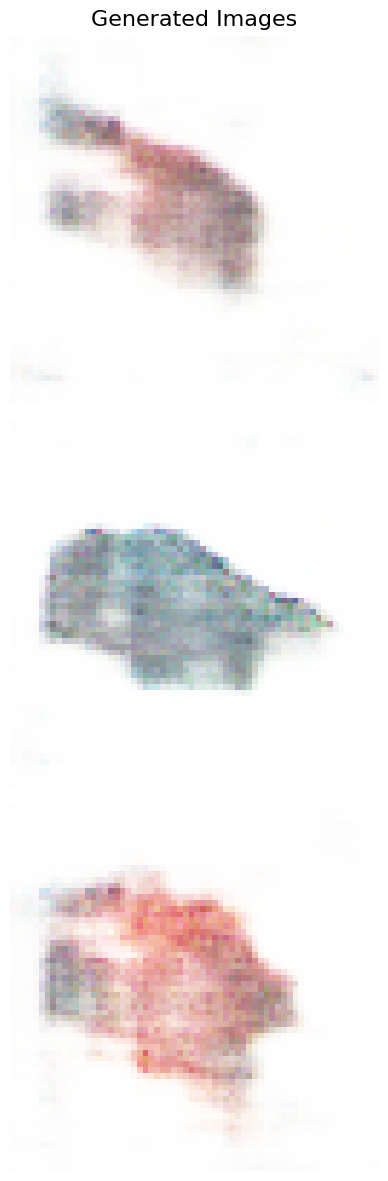

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def generate_image_from_caption(caption, tokenizer, stage2_gen, max_caption_len, noise_dim=100):
    # Preprocess caption
    tokens = tokenizer.texts_to_sequences([caption])
    padded_caption = tf.keras.preprocessing.sequence.pad_sequences(tokens, maxlen=max_caption_len, padding='post')

    # Convert to tensor
    padded_caption = tf.convert_to_tensor(padded_caption)

    # Generate random noise
    noise = tf.random.normal([1, noise_dim])

    # Generate image
    generated_image = stage2_gen([noise, padded_caption], training=False)[0].numpy()

    # Scale image from [-1, 1] to [0, 1]
    generated_image = (generated_image + 1) / 2.0

    plt.imshow(generated_image)
    plt.axis('off')
    plt.title("Generated Image")
    plt.show()
test_caption = "casual Boys white Printed T-Shirt"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)
test_caption = "Men Dark Brown Formal Shoes"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)
test_caption = "Girl's Pink White Check Top Kidswear"
generate_image_from_caption(test_caption, tokenizer, stage2_gen, max_caption_len)


 **Stable Diffuision Fintuned**

In [ ]:
import pandas as pd

df_final = df[['ImageURL', 'CombinedTitle']]
df_final.to_csv("fashion_dataset_image_and_caption100.csv", index=False)
print("CSV with ImagePath and final_caption saved successfully!")


✅ CSV with ImagePath and final_caption saved successfully!


In [ ]:
import pandas as pd
from diffusers import StableDiffusionPipeline, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTokenizer, CLIPTextModel
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import requests
from io import BytesIO
from tqdm import tqdm

# Dataset class
class FashionDataset(Dataset):
    def __init__(self, dataset_path):
        self.dataset = pd.read_csv(dataset_path)
        self.transform = transforms.Compose([
            transforms.Resize((256, 256)),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5]),
        ])
        self.tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        row = self.dataset.iloc[idx]
        image_url = row["ImageURL"]
        caption = row["CombinedTitle"]

        try:
            response = requests.get(image_url)
            image = Image.open(BytesIO(response.content)).convert("RGB")
        except Exception as e:
            print(f"Error downloading image {image_url}: {e}")
            image = Image.new("RGB", (256, 256))

        image = self.transform(image)
        token = self.tokenizer(caption, padding="max_length", truncation=True, max_length=77, return_tensors="pt")

        return {"pixel_values": image, "input_ids": token["input_ids"].squeeze(0)}

# Training function
def train():
    dataset_path = "/kaggle/working/fashion_dataset_image_and_caption100.csv"
    train_dataset = FashionDataset(dataset_path)
    dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device).half()
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device).half()
    unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet").to(device).half()

    unet.enable_gradient_checkpointing()
    text_encoder.gradient_checkpointing_enable()

    optimizer = torch.optim.AdamW(unet.parameters(), lr=1e-4)

    for epoch in range(3):
        for batch in tqdm(dataloader):
            images = batch["pixel_values"].to(device).half()
            input_ids = batch["input_ids"].to(device)

            with torch.no_grad():
                latents = vae.encode(images).latent_dist.sample() * 0.18215

            noise = torch.randn_like(latents).to(device)
            timesteps = torch.randint(0, 1000, (latents.shape[0],), device=device).long()
            noisy_latents = latents + noise
            encoder_hidden_states = text_encoder(input_ids)[0]

            noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample
            loss = torch.nn.functional.mse_loss(noise_pred, noise)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            torch.cuda.empty_cache()

        print(f"Epoch {epoch + 1}")

    unet.save_pretrained("fashion_lora_output")

if __name__ == "__main__":
    train()


tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/961k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.52k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

100%|██████████| 2906/2906 [27:41<00:00,  1.75it/s]


Epoch 1


100%|██████████| 2906/2906 [27:46<00:00,  1.74it/s]


Epoch 2


100%|██████████| 2906/2906 [30:09<00:00,  1.61it/s]


Epoch 3


**Testing on finetuned**

You have disabled the safety checker for <class 'diffusers.pipelines.stable_diffusion.pipeline_stable_diffusion.StableDiffusionPipeline'> by passing `safety_checker=None`. Ensure that you abide to the conditions of the Stable Diffusion license and do not expose unfiltered results in services or applications open to the public. Both the diffusers team and Hugging Face strongly recommend to keep the safety filter enabled in all public facing circumstances, disabling it only for use-cases that involve analyzing network behavior or auditing its results. For more information, please have a look at https://github.com/huggingface/diffusers/pull/254 .


Generating image 1 for prompt: casual men white tshirt


  0%|          | 0/50 [00:00<?, ?it/s]

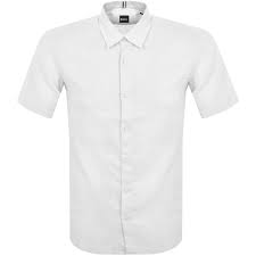

Generating image 2 for prompt: casual girl greens shirt kidswear


  0%|          | 0/50 [00:00<?, ?it/s]

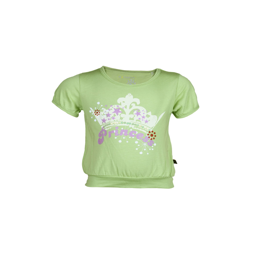

Generating image 3 for prompt: casual men black running shoes


  0%|          | 0/50 [00:00<?, ?it/s]

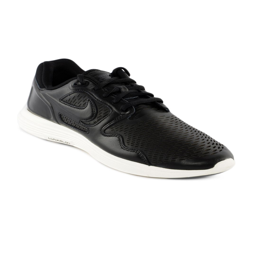

Generating image 4 for prompt: formal men brown shoes


  0%|          | 0/50 [00:00<?, ?it/s]

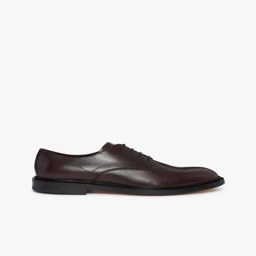

In [ ]:
from diffusers import StableDiffusionPipeline, DDIMScheduler, AutoencoderKL, UNet2DConditionModel
from transformers import CLIPTextModel, CLIPTokenizer
import torch

def generate_images(prompts):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    # Load components
    tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
    text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(device)
    vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae").to(device)
    unet = UNet2DConditionModel.from_pretrained("fashion_lora_output").to(device)
    scheduler = DDIMScheduler.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="scheduler")

    # Load Stable Diffusion pipeline
    pipe = StableDiffusionPipeline(
        vae=vae,
        text_encoder=text_encoder,
        tokenizer=tokenizer,
        unet=unet,
        scheduler=scheduler,
        safety_checker=None,
        feature_extractor=None,
    ).to(device)

    for i, prompt in enumerate(prompts):
        print(f"Generating image {i+1} for prompt: {prompt}")
        image = pipe(prompt=prompt, num_inference_steps=50, guidance_scale=7.5).images[0]
        image.show()

fashion_prompts = [
    "casual men white tshirt",
    "casual girl greens shirt kidswear",
    "casual men black running shoes",
    "formal men brown shoes",
]

generate_images(fashion_prompts)


# **Prompts:**

In [ ]:
#I’m working on a project where I want to generate images from text descriptions, specifically fashion product captions. Can you suggest the best deep learning models or architectures for text-to-image generation
# explain which ones are suitable for high-quality and semantically accurate outputs? Also, which ones work well with small or medium-sized datasets?


**Tokenizer Error**

In [ ]:

# Storing raw captions (df['CombinedTitle']) instead of the padded captions (padded_captions)
# Potential mismatch between num_words=2456 and actual vocabulary:




# **GAN**

In [ ]:
#i have a fashion dataset where captions are just combined titles and images are in url form. what do i need to do to train gan
#1)ValueError: Input 0 of layer "functional_1" is incompatible with the layer: expected shape=(None, 64, 64, 3), found shape=(None, 128, 128, 3)

 # WHY NY GENERATED IMAGES IS BLURRY AT 10 EPOCHOS

 #how can I improve the quality and diversity of generated fashion images when conditioning on text captions
 #3)Error:ValueError: Shapes (None, 64) and (None, 256) are incompatible.fix error

# Why my images are blurry


# style gan

In [ ]:
#  1. Using build_text_encoder() Twice Creates Two Separate Models  Issue: You are calling build_text_encoder() separately in both the generator and discriminator, which creates two different instances with unshared weights.


# 3. Untrained Text Encoder During GAN Training Issue: Even if shared, the text encoder must be trainable. If you freeze it (common mistake), it won’t adapt to the generator/discriminator’s needs.
# Inconsistent Feature Dimension in Discriminator  Issue: You reshape text features to (64, 64, 1) using this line:
#WHY NY GENERATED IMAGES IS BLURRY AT  600 EPOCHOS now suggest my another model for better image gneration

# attention gan

In [ ]:
#  can you add attention layer into my gan model here is my gan code
#  why my images are blurry

# stack gan

In [ ]:
#Can you suggest and implement architectural improvements to enhance the initial image generation
# My discriminators (Stage I and II) aren't performing well. I added more Conv2D layers and increased filters up to 256, but training remains unstable. Can you redesign both discriminators with better feature extraction
# In Stage II Generator, I upscale from 64x64 to 256x256 using Conv2DTranspose layers, but the output is still blurry. Can you revise the upsampling strategy

stable diffusion

In [ ]:
#Write a PyTorch training script that fine-tunes just the U-Net part of Stable Diffusion using a custom fashion dataset. The dataset includes images (from links) and their captions
#Use the diffusers library to load Stable Diffusion components. Use CLIP to turn the captions into vectors, and AutoencoderKL to turn the images into a compressed form.
#The script should download the images from the internet using their URLs and process the captions with CLIP's tokenizer."
#Now how can i geanearte image from finetuned model

evalution

In [ ]:
#  suggest some evvalution score for imgage genration